# **GESTURE RECOGNITION ASSIGNMENT**

DEEP LEARNING - IIITB COURSE PROJECT

## **Problem Statement**
You are tasked with developing a smart TV feature that recognizes five gestures to control the TV without a remote. Using a webcam mounted on the TV, gestures are continuously monitored, with each gesture performing a specific action:

| **Gesture**       | **Action**                    |
|--------------------|-------------------------------|
| **1. Thumbs Up**   | Increase the volume           |
| **2. Thumbs Down** | Decrease the volume           |
| **3. Left Swipe**  | Jump backward 10 seconds      |
| **4. Right Swipe** | Jump forward 10 seconds       |
| **5. Stop**        | Pause the movie               |

Each gesture is captured as a 30-frame video.

---

## **Objective**
Build a **gesture recognition model** with the following requirements:
1. **Generator**: A custom generator that preprocesses video data (cropping, resizing, and normalization) and efficiently feeds batches into the model.
2. **Model**: The final implementation will include both:
   - **3D Convolutional Networks (Conv3D)** to capture spatiotemporal patterns directly from the video frames.
   - **CNN + RNN** architecture, where a 2D CNN extracts spatial features from each frame, and an RNN (e.g., GRU or LSTM) captures temporal relationships across frames.
3. **Performance**: Ensure the model is accurate, optimized for inference speed, and generalizes well to unseen data.

In [16]:
## Checking the GPU configuration

!nvidia-smi

Wed Jan  8 14:57:03 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro RTX 5000                Off | 00000000:1B:00.0 Off |                  Off |
| 33%   31C    P8              11W / 230W |  15546MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [17]:
# Essential imports
import numpy as np
import os
import datetime
import warnings
warnings.filterwarnings("ignore")
from sys import getsizeof


# Image processing
from PIL import Image  # Replace scipy.misc.imread/imresize
import cv2

# Deep learning imports
import tensorflow as tf
import random as rn

We set the random seed so that the results don't vary drastically.

In [18]:
# Set random seeds for reproducibility
np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)  # Updated from tf.set_random_seed

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [19]:
# importing some other libraries which will be needed for model building.

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout

In [20]:
project_folder='datasets/Project_data'

##### Plotting

In [21]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [22]:
from abc import ABC, abstractmethod
import numpy as np
import os
import datetime
import cv2
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from PIL import Image

class ModelBuilder(ABC):
    def initialize_path(self, project_folder):
        """Initialize data paths and sequences"""
        self.train_doc = np.random.permutation(open(os.path.join(project_folder, 'train.csv')).readlines())
        self.val_doc = np.random.permutation(open(os.path.join(project_folder, 'val.csv')).readlines())
        self.train_path = os.path.join(project_folder, 'train')
        self.val_path = os.path.join(project_folder, 'val')
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
    
    def initialize_image_properties(self, image_height=100, image_width=100):
        """Initialize image dimensions and properties"""
        self.image_height = image_height
        self.image_width = image_width
        self.channels = 3
        self.num_classes = 5
        self.total_frames = 30
    
    def initialize_hyperparams(self, frames_to_sample=30, batch_size=20, num_epochs=20):
        """Initialize training hyperparameters"""
        self.frames_to_sample = frames_to_sample
        self.batch_size = batch_size
        self.num_epochs = num_epochs
    
    def generator(self, source_path, folder_list, augment=False):
        """Data generator for video frames"""
        img_idx = np.round(np.linspace(0, self.total_frames-1, self.frames_to_sample)).astype(int)
        batch_size = self.batch_size
        
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t) // batch_size
            
            for batch in range(num_batches):
                batch_data, batch_labels = self.one_batch_data(source_path, t, batch, batch_size, img_idx, augment)
                yield batch_data, batch_labels
            
            remaining_seq = len(t) % batch_size
            if remaining_seq != 0:
                batch_data, batch_labels = self.one_batch_data(source_path, t, num_batches, batch_size, 
                                                             img_idx, augment, remaining_seq)
                yield batch_data, batch_labels
    
    def one_batch_data(self, source_path, t, batch, batch_size, img_idx, augment, remaining_seq=0):
        """Process one batch of data"""
        seq_len = remaining_seq if remaining_seq else batch_size
        batch_data = np.zeros((seq_len, len(img_idx), self.image_height, self.image_width, self.channels))
        batch_labels = np.zeros((seq_len, self.num_classes))
        
        if augment:
            batch_data_aug = np.zeros((seq_len, len(img_idx), self.image_height, self.image_width, self.channels))
        
        for folder in range(seq_len):
            folder_path = os.path.join(source_path, t[folder + (batch*batch_size)].split(';')[0].strip())
            imgs = os.listdir(folder_path)
            
            for idx, item in enumerate(img_idx):
                # Read and process image
                image_path = os.path.join(folder_path, imgs[item])
                image = np.array(Image.open(image_path)).astype(np.float32)
                image_resized = np.array(Image.fromarray(image.astype('uint8')).resize(
                    (self.image_width, self.image_height)))
                
                # Normalize image
                batch_data[folder, idx] = image_resized / 255.0
                
                if augment:
                    # Apply augmentation
                    shifted = cv2.warpAffine(image, 
                        np.float32([[1, 0, np.random.randint(-30,30)],
                                  [0, 1, np.random.randint(-30,30)]]), 
                        (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0)
                    cropped = shifted[x0:x1, y0:y1, :]
                    
                    image_resized = np.array(Image.fromarray(cropped.astype('uint8')).resize(
                        (self.image_width, self.image_height)))
                    batch_data_aug[folder, idx] = image_resized / 255.0
            
            # Set label
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
        
        if augment:
            batch_data = np.concatenate([batch_data, batch_data_aug])
            batch_labels = np.concatenate([batch_labels, batch_labels])
        
        return batch_data, batch_labels
    
    def train_model(self, model, augment_data=False):
        """Train the model"""
        train_generator = self.generator(self.train_path, self.train_doc, augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)
        
        model_name = f'model_init_{datetime.datetime.now().strftime("%Y%m%d_%H%M%S")}'
        os.makedirs(model_name, exist_ok=True)
        
        # Setup callbacks
        callbacks = [
            ModelCheckpoint(
                filepath=os.path.join(model_name, 
                    'model-{epoch:05d}-{val_categorical_accuracy:.5f}.keras'),
                monitor='val_categorical_accuracy',
                save_best_only=True,
                mode='max',
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=4,
                verbose=1
            ),
            EarlyStopping(
                monitor="val_loss",
                patience=10,
                verbose=1,
                restore_best_weights=True
            )
        ]
        
        # Calculate steps
        steps_per_epoch = (self.num_train_sequences + self.batch_size - 1) // self.batch_size
        validation_steps = (self.num_val_sequences + self.batch_size - 1) // self.batch_size
        
        # Train model
        history = model.fit(
            train_generator,
            steps_per_epoch=steps_per_epoch,
            epochs=self.num_epochs,
            validation_data=val_generator,
            validation_steps=validation_steps,
            callbacks=callbacks,
            workers=1
        )
        
        return history
    
    @abstractmethod
    def define_model(self):
        """Abstract method to define the model architecture"""
        pass

def plot_training_history(history):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
    
    # Plot loss
    ax1.plot(history.history['loss'], label='Training')
    ax1.plot(history.history['val_loss'], label='Validation')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracy
    ax2.plot(history.history['categorical_accuracy'], label='Training')
    ax2.plot(history.history['val_categorical_accuracy'], label='Validation')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv3D, MaxPooling3D, BatchNormalization, Dense, Dropout, GlobalAveragePooling3D
)
from tensorflow.keras.optimizers import Adam

class GestureModel(ModelBuilder):
    def define_model(self):
        model = Sequential([
            # First 3D Conv block
            Conv3D(32, kernel_size=(3, 3, 3), padding='same', activation='relu',
                  input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels),
                  kernel_regularizer=tf.keras.regularizers.l2(1e-5)),
            BatchNormalization(),
            Conv3D(32, kernel_size=(3, 3, 3), padding='same', activation='relu',
                  kernel_regularizer=tf.keras.regularizers.l2(1e-5)),
            BatchNormalization(),
            MaxPooling3D(pool_size=(1, 2, 2)),
            Dropout(0.2),

            # Second 3D Conv block
            Conv3D(64, kernel_size=(3, 3, 3), padding='same', activation='relu',
                  kernel_regularizer=tf.keras.regularizers.l2(1e-5)),
            BatchNormalization(),
            Conv3D(64, kernel_size=(3, 3, 3), padding='same', activation='relu',
                  kernel_regularizer=tf.keras.regularizers.l2(1e-5)),
            BatchNormalization(),
            MaxPooling3D(pool_size=(2, 2, 2)),
            Dropout(0.3),

            # Third 3D Conv block
            Conv3D(128, kernel_size=(3, 3, 3), padding='same', activation='relu',
                  kernel_regularizer=tf.keras.regularizers.l2(1e-5)),
            BatchNormalization(),
            Conv3D(128, kernel_size=(1, 1, 1), padding='same', activation='relu',
                  kernel_regularizer=tf.keras.regularizers.l2(1e-5)),
            BatchNormalization(),
            MaxPooling3D(pool_size=(2, 2, 2)),
            Dropout(0.4),

            # Global pooling
            GlobalAveragePooling3D(),
            
            # Dense layers
            Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-5)),
            BatchNormalization(),
            Dropout(0.5),
            
            # Output layer
            Dense(self.num_classes, activation='softmax')
        ])

        # Compile model
        optimizer = Adam(learning_rate=0.001)
        model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['categorical_accuracy']
        )
        
        return model

# Usage
project_folder = 'datasets/Project_data'

# Initialize model
model_builder = GestureModel()
model_builder.initialize_path(project_folder)
model_builder.initialize_image_properties(image_height=120, image_width=120)
model_builder.initialize_hyperparams(frames_to_sample=30, batch_size=32, num_epochs=50)

# Get model and train
model = model_builder.define_model()
print(model.summary())  # Print model architecture

# Train model
history = model_builder.train_model(model, augment_data=True)

# Plot results
plot_training_history(history)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 30, 120, 120, 32)  2624      
                                                                 
 batch_normalization_7 (Batc  (None, 30, 120, 120, 32)  128      
 hNormalization)                                                 
                                                                 
 conv3d_7 (Conv3D)           (None, 30, 120, 120, 32)  27680     
                                                                 
 batch_normalization_8 (Batc  (None, 30, 120, 120, 32)  128      
 hNormalization)                                                 
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 30, 60, 60, 32)   0         
 3D)                                                             
                                                      

2025-01-08 14:58:44.483082: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.31GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2025-01-08 14:58:57.966888: W tensorflow/core/common_runtime/bfc_allocator.cc:463] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.30GiB (rounded to 3538944000)requested by op sequential_1/batch_normalization_8/FusedBatchNormV3
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-01-08 14:58:57.966949: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2025-01-08 14:58:57.966967: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 166, Chunks in use: 166

ResourceExhaustedError:  OOM when allocating tensor with shape[64,32,30,14400] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential_1/batch_normalization_8/FusedBatchNormV3
 (defined at /usr/local/lib/python3.8/dist-packages/keras/layers/normalization/batch_normalization.py:589)
]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_5283]

Errors may have originated from an input operation.
Input Source operations connected to node sequential_1/batch_normalization_8/FusedBatchNormV3:
In[0] sequential_1/conv3d_7/Relu (defined at /usr/local/lib/python3.8/dist-packages/keras/backend.py:4867)	
In[1] sequential_1/batch_normalization_8/ReadVariableOp:	
In[2] sequential_1/batch_normalization_8/ReadVariableOp_1:	
In[3] sequential_1/batch_normalization_8/FusedBatchNormV3/ReadVariableOp:	
In[4] sequential_1/batch_normalization_8/FusedBatchNormV3/ReadVariableOp_1:

Operation defined at: (most recent call last)
>>>   File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 450, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 357, in dispatch_shell
>>>     await result
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 652, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py", line 359, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/zmqshell.py", line 532, in run_cell
>>>     return super().run_cell(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2914, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3185, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3457, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/tmp/ipykernel_232/1067096549.py", line 77, in <module>
>>>     history = model_builder.train_model(model, augment_data=True)
>>> 
>>>   File "/tmp/ipykernel_232/2604585822.py", line 137, in train_model
>>>     history = model.fit(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 808, in train_step
>>>     y_pred = self(x, training=True)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/sequential.py", line 373, in call
>>>     return super(Sequential, self).call(inputs, training=training, mask=mask)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py", line 451, in call
>>>     return self._run_internal_graph(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/layers/normalization/batch_normalization.py", line 767, in call
>>>     outputs = self._fused_batch_norm(inputs, training=training)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/layers/normalization/batch_normalization.py", line 623, in _fused_batch_norm
>>>     output, mean, variance = control_flow_util.smart_cond(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/control_flow_util.py", line 105, in smart_cond
>>>     return tf.__internal__.smart_cond.smart_cond(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/layers/normalization/batch_normalization.py", line 589, in _fused_batch_norm_training
>>>     return tf.compat.v1.nn.fused_batch_norm(
>>> 

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Sample Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv3D, MaxPooling3D, BatchNormalization, Dense, Dropout, 
    Flatten, Activation
)
from tensorflow.keras.optimizers import Adam

class ModelConv3D1(ModelBuilder):
    def define_model(self):
        # Enable mixed precision for better performance
        tf.keras.mixed_precision.set_global_policy('mixed_float16')
        
        model = Sequential([
            # First Conv3D block
            Conv3D(16, (3, 3, 3), 
                  padding='same',
                  activation='relu',
                  kernel_regularizer=tf.keras.regularizers.l2(1e-5),
                  input_shape=(self.frames_to_sample, self.image_height, 
                             self.image_width, self.channels)),
            BatchNormalization(),
            MaxPooling3D(pool_size=(1, 2, 2)),
            Dropout(0.2),
            
            # Second Conv3D block - increased filters
            Conv3D(48, (2, 2, 2), 
                  padding='same',
                  activation='relu',
                  kernel_regularizer=tf.keras.regularizers.l2(1e-5)),
            BatchNormalization(),
            MaxPooling3D(pool_size=(2, 2, 2)),
            Dropout(0.3),
            
            # Third Conv3D block
            Conv3D(96, (2, 2, 2), 
                  padding='same',
                  activation='relu',
                  kernel_regularizer=tf.keras.regularizers.l2(1e-5)),
            BatchNormalization(),
            MaxPooling3D(pool_size=(2, 2, 2)),
            Dropout(0.3),
            
            # Fourth Conv3D block
            Conv3D(192, (2, 2, 2), 
                  padding='same',
                  activation='relu',
                  kernel_regularizer=tf.keras.regularizers.l2(1e-5)),
            BatchNormalization(),
            MaxPooling3D(pool_size=(2, 2, 2)),
            Dropout(0.4),
            
            Flatten(),
            
            Dense(256,  # Increased capacity
                 activation='relu',
                 kernel_regularizer=tf.keras.regularizers.l2(1e-5)),
            BatchNormalization(),
            Dropout(0.5),
            
            Dense(128,  # Increased capacity
                 activation='relu',
                 kernel_regularizer=tf.keras.regularizers.l2(1e-5)),
            BatchNormalization(),
            Dropout(0.5),
            
            Dense(self.num_classes, activation='softmax')
        ])
        
        # Optimizer with warmup and cosine decay
        initial_learning_rate = 0.001
        decay_steps = 1000
        lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
            initial_learning_rate,
            decay_steps,
            t_mul=2.0,
            m_mul=0.9,
            alpha=1e-5
        )
        
        optimizer = Adam(
            learning_rate=lr_schedule,
            clipnorm=1.0,
            epsilon=1e-8  # Added for numerical stability
        )
        
        model.compile(
            optimizer=optimizer,
            loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
            metrics=[
                'categorical_accuracy',
                tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top_2_accuracy'),
                tf.keras.metrics.AUC(name='auc')  # Added AUC metric
            ]
        )
        
        return model

In [ ]:
# GPU configuration - must be at the very start
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
        print(f"GPU memory growth enabled on {len(physical_devices)} device(s)")
    except RuntimeError as e:
        print(f"GPU configuration error: {e}")

import os
import numpy as np
import matplotlib.pyplot as plt

def setup_and_train_model(project_folder, image_size=160, batch_size=32, epochs=50):
    """Setup and train the 3D CNN model"""
    try:
        # Initialize model
        conv_3d_model = ModelConv3D1()
        conv_3d_model.initialize_path(project_folder)
        conv_3d_model.initialize_image_properties(
            image_height=image_size,
            image_width=image_size
        )
        
        # Set training parameters
        conv_3d_model.initialize_hyperparams(
            frames_to_sample=30,
            batch_size=batch_size,
            num_epochs=epochs
        )
        
        # Create model
        model = conv_3d_model.define_model()
        
        # Print model summary
        model.summary()
        trainable_params = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
        print(f"\nTrainable parameters: {trainable_params:,}")
        
        return model, conv_3d_model
    
    except Exception as e:
        print(f"Error in model setup: {str(e)}")
        raise

def visualize_augmented_samples(project_folder, image_size=160, num_samples=5):
    """Visualize original and augmented samples"""
    try:
        # Initialize test generator
        test_generator = ModelConv3D1()
        test_generator.initialize_path(project_folder)
        test_generator.initialize_image_properties(
            image_height=image_size,
            image_width=image_size
        )
        
        # Setup generator parameters
        test_generator.initialize_hyperparams(
            frames_to_sample=30,
            batch_size=num_samples,
            num_epochs=1
        )
        
        # Get batch of data
        g = test_generator.generator(
            test_generator.val_path,
            test_generator.val_doc,
            augment=True
        )
        batch_data, batch_labels = next(g)
        
        # Visualization
        fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
        fig.suptitle('Original vs Augmented Samples (Middle Frame)', fontsize=12)
        
        # Show original samples
        for i in range(num_samples):
            if i == 0:
                axes[0, i].set_ylabel('Original')
            axes[0, i].imshow(batch_data[i, 15, :, :, :])
            axes[0, i].axis('off')
            axes[0, i].set_title(f'Sample {i+1}')
        
        # Show augmented samples
        for i in range(num_samples):
            if i == 0:
                axes[1, i].set_ylabel('Augmented')
            axes[1, i].imshow(batch_data[i + num_samples, 15, :, :, :])
            axes[1, i].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        return batch_data, batch_labels
    
    except Exception as e:
        print(f"Error in visualization: {str(e)}")
        raise

# Usage
try:
    # Model setup and training
    model, model_instance = setup_and_train_model(
        project_folder=project_folder,
        image_size=160,
        batch_size=32,
        epochs=50
    )
    
    # Visualization
    batch_data, batch_labels = visualize_augmented_samples(
        project_folder=project_folder,
        image_size=160,
        num_samples=5
    )
    
except Exception as e:
    print(f"Error in execution: {str(e)}")

##### Sample Cropping

In [ ]:
# Quick test with small batch
model, model_instance = setup_and_train_model(
    project_folder,
    image_size=160,
    batch_size=8  # Small for testing
)

# Visualize some samples
batch_data, batch_labels = visualize_augmented_samples(
    project_folder,
    image_size=160,
    num_samples=3  # Number of samples to show
)

## Experimenting with Image resolution, number of frames to use and batch_size

In [24]:
class ModelConv3D1(ModelBuilder):
    def define_model(self):
        model = Sequential([
            # First Conv3D block
            Conv3D(16, (3, 3, 3), 
                   padding='same',
                   activation='relu',
                   kernel_regularizer=tf.keras.regularizers.l2(1e-5),
                   input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)),
            BatchNormalization(),
            MaxPooling3D(pool_size=(1, 2, 2)),
            Dropout(0.2),
            
            # Second Conv3D block
            Conv3D(48, (2, 2, 2), 
                   padding='same',
                   activation='relu',
                   kernel_regularizer=tf.keras.regularizers.l2(1e-5)),
            BatchNormalization(),
            MaxPooling3D(pool_size=(2, 2, 2)),
            Dropout(0.3),
            
            # Third Conv3D block
            Conv3D(96, (2, 2, 2), 
                   padding='same',
                   activation='relu',
                   kernel_regularizer=tf.keras.regularizers.l2(1e-5)),
            BatchNormalization(),
            MaxPooling3D(pool_size=(2, 2, 2)),
            Dropout(0.3),
            
            # Fourth Conv3D block
            Conv3D(192, (2, 2, 2), 
                   padding='same',
                   activation='relu',
                   kernel_regularizer=tf.keras.regularizers.l2(1e-5)),
            BatchNormalization(),
            MaxPooling3D(pool_size=(2, 2, 2)),
            Dropout(0.4),
            
            # Replace Flatten with Global Average Pooling
            GlobalAveragePooling3D(),
            
            # Dense layers
            Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-5)),
            BatchNormalization(),
            Dropout(0.5),
            
            Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-5)),
            BatchNormalization(),
            Dropout(0.5),
            
            Dense(self.num_classes, activation='softmax')
        ])
        
        # Compile the model
        optimizer = Adam(learning_rate=0.001)
        model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['categorical_accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top_2_accuracy'), tf.keras.metrics.AUC(name='auc')]
        )
        
        return model


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 16, 64, 64, 16)    1312      
                                                                 
 batch_normalization_14 (Bat  (None, 16, 64, 64, 16)   64        
 chNormalization)                                                
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 16, 32, 32, 16)   0         
 3D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 16, 32, 32, 16)    0         
                                                                 
 conv3d_13 (Conv3D)          (None, 16, 32, 32, 48)    6192      
                                                                 
 batch_normalization_15 (Bat  (None, 16, 32, 32, 48)  

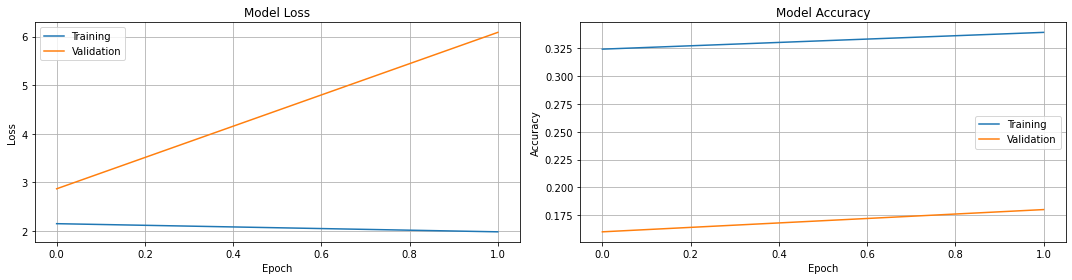

In [25]:
# Reinitialize and test
conv_3d1 = ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=64, image_width=64)  # Testing with smaller dimensions
conv_3d1.initialize_hyperparams(frames_to_sample=16, batch_size=8, num_epochs=2)  # Quick run

# Define the model
conv_3d1_model = conv_3d1.define_model()
print(conv_3d1_model.summary())

# Train the model
history = conv_3d1.train_model(conv_3d1_model, augment_data=False)

# Plot training history
plot_training_history(history)


##### Below are the experiments to see how training time is affected by image resolution, number of images in sequence and batch size

In [26]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=15,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 278005
Epoch 1/2
23/23 [==============================] - ETA: 0s - loss: 2.0187 - categorical_accuracy: 0.3560 - top_2_accuracy: 0.5958 - auc: 0.6767
Epoch 00001: val_categorical_accuracy improved from -inf to 0.16000, saving model to model_init_20250108_150024/model-00001-0.16000.keras
23/23 [==============================] - 38s 2s/step - loss: 2.0187 - categorical_accuracy: 0.3560 - top_2_accuracy: 0.5958 - auc: 0.6767 - val_loss: 1.8420 - val_categorical_accuracy: 0.1600 - val_top_2_accuracy: 0.3700 - val_auc: 0.4773 - lr: 0.0010
Epoch 2/2
23/23 [==============================] - ETA: 0s - loss: 1.6864 - categorical_accuracy: 0.3937 - top_2_accuracy: 0.6787 - auc: 0.7498
Epoch 00002: val_categorical_accuracy did not improve from 0.16000
23/23 [==============================] - 35s 2s/step - loss: 1.6864 - categorical_accuracy: 0.3937 - top_2_accuracy: 0.6787 - auc: 0.7498 - val_loss: 2.7014 - val_categorical_accuracy: 0.1400 - val_top_2_accuracy: 0.3400 - val_auc: 0.

In [26]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 278005
Epoch 1/2
34/34 [==============================] - ETA: 0s - loss: 2.2293 - categorical_accuracy: 0.3122 - top_2_accuracy: 0.5294 - auc: 0.6215
Epoch 00001: val_categorical_accuracy improved from -inf to 0.21000, saving model to model_init_20250108_051054/model-00001-0.21000.keras
34/34 [==============================] - 74s 2s/step - loss: 2.2293 - categorical_accuracy: 0.3122 - top_2_accuracy: 0.5294 - auc: 0.6215 - val_loss: 1.9315 - val_categorical_accuracy: 0.2100 - val_top_2_accuracy: 0.3700 - val_auc: 0.4807 - lr: 0.0010
Epoch 2/2
34/34 [==============================] - ETA: 0s - loss: 1.6995 - categorical_accuracy: 0.3997 - top_2_accuracy: 0.6998 - auc: 0.7310
Epoch 00002: val_categorical_accuracy did not improve from 0.21000
34/34 [==============================] - 67s 2s/step - loss: 1.6995 - categorical_accuracy: 0.3997 - top_2_accuracy: 0.6998 - auc: 0.7310 - val_loss: 3.1745 - val_categorical_accuracy: 0.2100 - val_top_2_accuracy: 0.4100 - val_auc: 0.

In [27]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 278005
Epoch 1/2
45/45 [==============================] - ETA: 0s - loss: 1.9961 - categorical_accuracy: 0.3605 - top_2_accuracy: 0.6063 - auc: 0.6751
Epoch 00001: val_categorical_accuracy improved from -inf to 0.21000, saving model to model_init_20250108_051317/model-00001-0.21000.keras
45/45 [==============================] - 86s 2s/step - loss: 1.9961 - categorical_accuracy: 0.3605 - top_2_accuracy: 0.6063 - auc: 0.6751 - val_loss: 1.8927 - val_categorical_accuracy: 0.2100 - val_top_2_accuracy: 0.3700 - val_auc: 0.4774 - lr: 0.0010
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 1.6811 - categorical_accuracy: 0.4103 - top_2_accuracy: 0.7014 - auc: 0.7416
Epoch 00002: val_categorical_accuracy improved from 0.21000 to 0.23000, saving model to model_init_20250108_051317/model-00002-0.23000.keras
45/45 [==============================] - 82s 2s/step - loss: 1.6811 - categorical_accuracy: 0.4103 - top_2_accuracy: 0.7014 - auc: 0.7416 - val_loss: 3.1385 - v

In [28]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 278005
Epoch 1/2
23/23 [==============================] - ETA: 0s - loss: 2.2864 - categorical_accuracy: 0.3032 - top_2_accuracy: 0.5309 - auc: 0.6161
Epoch 00001: val_categorical_accuracy improved from -inf to 0.21000, saving model to model_init_20250108_051606/model-00001-0.21000.keras
23/23 [==============================] - 47s 2s/step - loss: 2.2864 - categorical_accuracy: 0.3032 - top_2_accuracy: 0.5309 - auc: 0.6161 - val_loss: 1.8011 - val_categorical_accuracy: 0.2100 - val_top_2_accuracy: 0.3700 - val_auc: 0.5100 - lr: 0.0010
Epoch 2/2
23/23 [==============================] - ETA: 0s - loss: 1.7973 - categorical_accuracy: 0.3906 - top_2_accuracy: 0.7089 - auc: 0.7327
Epoch 00002: val_categorical_accuracy improved from 0.21000 to 0.25000, saving model to model_init_20250108_051606/model-00002-0.25000.keras
23/23 [==============================] - 45s 2s/step - loss: 1.7973 - categorical_accuracy: 0.3906 - top_2_accuracy: 0.7089 - auc: 0.7327 - val_loss: 2.1042 - v

From the experiments above, it's evident that image resolution and the number of frames in a sequence have a more significant impact on training time compared to batch size. Larger resolutions and more frames increase computational complexity, which directly affects the training duration.

For optimal performance:

- Batch Size: A range between 15-40 provides a balance between GPU memory utilization and model stability.
- Resolution: Adjusting the resolution to 160x160 or 120x120 should depend on the model's ability to achieve a higher validation accuracy. Higher resolutions may offer better feature extraction but at the cost of increased training time.


## Model 1
### Base Model - Batch Size = 40 and No. of Epochs = 15

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, BatchNormalization, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy

class ModelConv3D1(ModelBuilder):
    def define_model(self, filtersize=(3, 3, 3), dense_neurons=64, dropout=0.25):
        model = Sequential()

        model.add(Conv3D(16, filtersize, padding='same', activation='relu',
                         input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same', activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same', activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same', activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))

        optimiser = Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=[CategoricalAccuracy()])
        return model

In [32]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_42 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 batch_normalization_61 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_39 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_43 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 batch_normalization_62 (Bat  (None, 10, 80, 80, 32)   128       
 chNormalization)                                                
                                                     

In [33]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061
Epoch 1/15
17/17 [==============================] - ETA: 0s - loss: 1.8341 - categorical_accuracy: 0.3620
Epoch 00001: val_categorical_accuracy improved from -inf to 0.35000, saving model to model_init_20250108_052011/model-00001-0.35000.keras
17/17 [==============================] - 58s 3s/step - loss: 1.8341 - categorical_accuracy: 0.3620 - val_loss: 1.6340 - val_categorical_accuracy: 0.3500 - lr: 0.0010
Epoch 2/15
17/17 [==============================] - ETA: 0s - loss: 0.9675 - categorical_accuracy: 0.6350
Epoch 00002: val_categorical_accuracy did not improve from 0.35000
17/17 [==============================] - 55s 3s/step - loss: 0.9675 - categorical_accuracy: 0.6350 - val_loss: 3.3570 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/15
17/17 [==============================] - ETA: 0s - loss: 0.6894 - categorical_accuracy: 0.7391
Epoch 00003: val_categorical_accuracy did not improve from 0.35000
17/17 [==============================] - 53s 3s/step - l

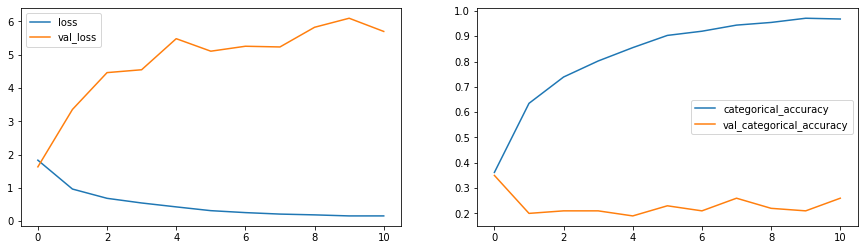

In [34]:
plot(history_model1)

### Conclusion for Model 1:
- **Best Validation Accuracy:** 35% (at epoch 1).
- **Best Training Accuracy:** 97.1% (at epoch 10).
- **Parameter Count:** 1.12M.
- **Overfitting:** Significant gap between training accuracy (97.1%) and validation accuracy (35%) indicates overfitting.
- **Early Stopping:** Effectively halted training at epoch 11/15 as validation accuracy did not improve further.
- **Validation Loss:** Increasing loss after epoch 1 suggests poor generalization.
- **Next Steps/Recommendations:**
  - Apply stronger regularization (e.g., dropout, L2 regularization).
  - Experiment with reducing the learning rate or using a learning rate schedule.
  - Increase data augmentation or expand the dataset to reduce overfitting.


## Model 2  
### Adding dropout layers - Batch Size = 20 and No. of Epochs = 25

In [35]:
conv_3d2=ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_46 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 batch_normalization_67 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_43 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_47 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 batch_normalization_68 (Bat  (None, 10, 80, 80, 32)   128       
 chNormalization)                                                
                                                     

In [36]:
print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

Total Params: 3638981
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.8983 - categorical_accuracy: 0.3793
Epoch 00001: val_categorical_accuracy improved from -inf to 0.21000, saving model to model_init_20250108_053039/model-00001-0.21000.keras
34/34 [==============================] - 113s 3s/step - loss: 1.8983 - categorical_accuracy: 0.3793 - val_loss: 3.6891 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.5036 - categorical_accuracy: 0.4917
Epoch 00002: val_categorical_accuracy improved from 0.21000 to 0.29000, saving model to model_init_20250108_053039/model-00002-0.29000.keras
34/34 [==============================] - 111s 3s/step - loss: 1.5036 - categorical_accuracy: 0.4917 - val_loss: 4.4355 - val_categorical_accuracy: 0.2900 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.3070 - categorical_accuracy: 0.5392
Epoch 00003: val_categorical_accuracy did not i

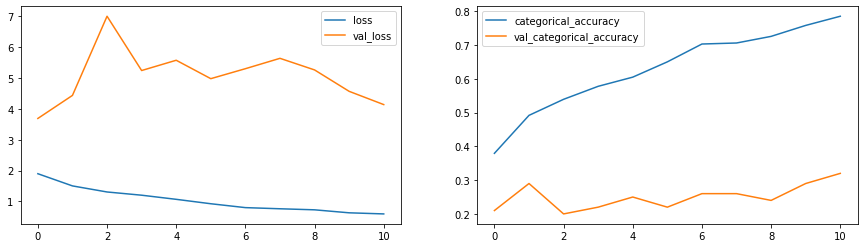

In [37]:
plot(history_model2)

### Conclusion for Model 2:
- **Best Validation Accuracy:** 32% (at epoch 11).
- **Best Training Accuracy:** 78.5% (at epoch 10).
- **Parameter Count:** 3.64M.
- **Overfitting:** Significant gap between training and validation accuracy indicates overfitting.
- **Validation Loss Oscillation:** Suggests potential instability in training, likely due to suboptimal learning rate or insufficient regularization.

### Comparison with Models 1 and 3:
- **Model 2 vs. Model 1:** Model 2 has a higher validation accuracy (32% vs. 29%) but is more computationally expensive with larger parameters (3.64M vs. 1.76M in Model 3).
### Next Steps/Recommendations:
- Experiment with **learning rate tuning** or use a **cyclical learning rate** to stabilize training.
- Apply **stronger regularization techniques** (e.g., dropout, L2 regularization, or weight decay).
- Focus on **data augmentation** or increasing dataset size to improve generalization.
- Consider testing smaller filter sizes and reduced image resolution for faster training and improved feature learning balance.


## Model 3 
### Reduce filter size to (2,2,2) and image res to 120 x  120, - Batch Size = 30 and No. of Epochs = 25

In [40]:
class ModelConv3D3(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))
        
        optimiser = tf.keras.optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [41]:
conv_3d3=ModelConv3D3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=120,image_width=120)
conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=25)
conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d3_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_54 (Conv3D)          (None, 16, 120, 120, 16)  400       
                                                                 
 activation_8 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_79 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_51 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_55 (Conv3D)          (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_9 (Activation)   (None, 8, 60, 60, 32)   

In [42]:
print("Total Params:", conv_3d3_model.count_params())
history_model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)

Total Params: 1762613
Epoch 1/25
23/23 [==============================] - ETA: 0s - loss: 2.3487 - categorical_accuracy: 0.2745
Epoch 00001: val_categorical_accuracy improved from -inf to 0.21000, saving model to model_init_20250108_055607/model-00001-0.21000.keras
23/23 [==============================] - 80s 4s/step - loss: 2.3487 - categorical_accuracy: 0.2745 - val_loss: 1.7222 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/25
23/23 [==============================] - ETA: 0s - loss: 1.6230 - categorical_accuracy: 0.4321
Epoch 00002: val_categorical_accuracy improved from 0.21000 to 0.22000, saving model to model_init_20250108_055607/model-00002-0.22000.keras
23/23 [==============================] - 75s 3s/step - loss: 1.6230 - categorical_accuracy: 0.4321 - val_loss: 2.3715 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04
Epoch 3/25
22/23 [===========================>..] - ETA: 3s - loss: 1.3640 - categorical_accuracy: 0.5333
Epoch 00003: val_categorical_accuracy did

In [44]:
def plot_with_details(history):
    """Plot training history with additional written details."""
    # Extract key metrics
    best_epoch = history.history['val_categorical_accuracy'].index(max(history.history['val_categorical_accuracy'])) + 1
    best_val_accuracy = max(history.history['val_categorical_accuracy'])
    best_val_loss = history.history['val_loss'][best_epoch - 1]
    final_train_accuracy = history.history['categorical_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Display metrics in written form
    print("\n--- Training Summary ---")
    print(f"Best Epoch: {best_epoch}")
    print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")
    print(f"Validation Loss at Best Epoch: {best_val_loss:.4f}")
    print(f"Final Training Accuracy: {final_train_accuracy:.4f}")
    print(f"Final Training Loss: {final_train_loss:.4f}\n")
    
    # Plot training/validation loss
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss
    axes[0].plot(history.history['loss'], label='loss')
    axes[0].plot(history.history['val_loss'], label='val_loss')
    axes[0].set_title("Loss Over Epochs")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    
    # Accuracy
    axes[1].plot(history.history['categorical_accuracy'], label='categorical_accuracy')
    axes[1].plot(history.history['val_categorical_accuracy'], label='val_categorical_accuracy')
    axes[1].set_title("Accuracy Over Epochs")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()


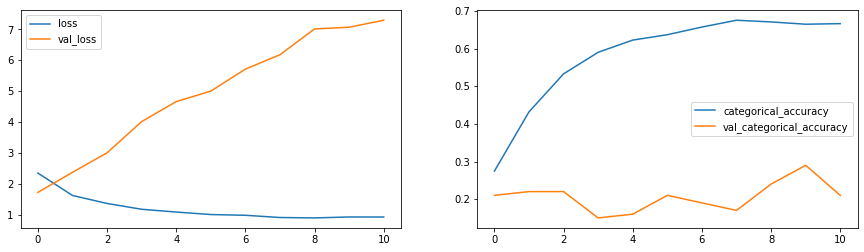

In [45]:
plot(history_model3)

### Conclusion for Model 3:
- **Best Validation Accuracy:** 29% (at epoch 10).
- **Best Training Accuracy:** 67% (at epoch 9).
- **Parameter Count:** 1.76M (50% less than Model 2's 3.64M).
- **Overfitting:** Training accuracy significantly higher than validation accuracy.
- **Comparison with Models 1 and 2:**
  - More efficient than Model 2 but lower validation accuracy (29% vs. 32%).
  - Slightly better parameter optimization and efficiency than Model 1.

### Next Steps:
- Enhance data augmentation or increase dataset size.
- Experiment with regularization (e.g., dropout, L2).
- Consider architectural improvements like adding layers or tweaking pooling.


## Model 4 - 
### Adding more layers, L2 Regularization - Batch Size = 20 and No. of Epochs = 25

In [46]:
class ModelConv3D4(ModelBuilder):
    
    def define_model(self, filtersize=(3,3,3), dense_neurons=64, dropout=0.25, l2_reg=1e-4):
        from tensorflow.keras.regularizers import l2
        
        model = Sequential()

        # First Conv Block
        model.add(Conv3D(16, filtersize, padding='same', kernel_regularizer=l2(l2_reg),
                         input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same', kernel_regularizer=l2(l2_reg)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # Second Conv Block
        model.add(Conv3D(32, filtersize, padding='same', kernel_regularizer=l2(l2_reg)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same', kernel_regularizer=l2(l2_reg)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # Third Conv Block
        model.add(Conv3D(64, filtersize, padding='same', kernel_regularizer=l2(l2_reg)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same', kernel_regularizer=l2(l2_reg)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # Fourth Conv Block
        model.add(Conv3D(128, filtersize, padding='same', kernel_regularizer=l2(l2_reg)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same', kernel_regularizer=l2(l2_reg)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        # Fully Connected Layers
        model.add(Flatten())
        model.add(Dense(dense_neurons, activation='relu', kernel_regularizer=l2(l2_reg)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons, activation='relu', kernel_regularizer=l2(l2_reg)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        # Output Layer
        model.add(Dense(self.num_classes, activation='softmax'))

        # Optimizer
        optimiser = tf.keras.optimizers.Adam(learning_rate=0.0002)  # Lowered LR based on feedback
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model

In [47]:
conv_3d4=ModelConv3D4()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height=120,image_width=120)
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d4_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_58 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_12 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_85 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_59 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_13 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_86 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                    

In [48]:
print("Total Params:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 2.3220 - categorical_accuracy: 0.3024
Epoch 00001: val_categorical_accuracy improved from -inf to 0.16000, saving model to model_init_20250108_062459/model-00001-0.16000.keras
34/34 [==============================] - 76s 2s/step - loss: 2.3220 - categorical_accuracy: 0.3024 - val_loss: 2.2713 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.7588 - categorical_accuracy: 0.4419
Epoch 00002: val_categorical_accuracy improved from 0.16000 to 0.18000, saving model to model_init_20250108_062459/model-00002-0.18000.keras
34/34 [==============================] - 75s 2s/step - loss: 1.7588 - categorical_accuracy: 0.4419 - val_loss: 3.5340 - val_categorical_accuracy: 0.1800 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.3965 - categorical_accuracy: 0.5618
Epoch 00003: val_categorical_accuracy did

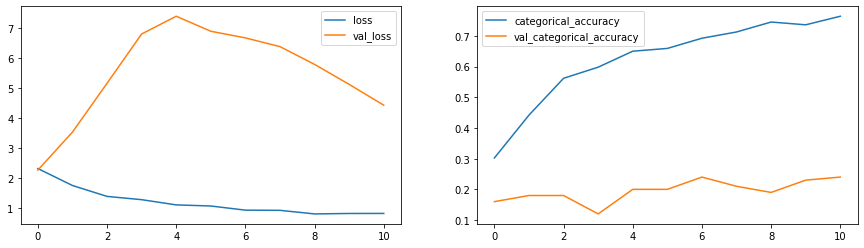

In [49]:
plot(history_model4)

### Conclusion for Model 4:
- **Best Validation Accuracy:** 24% (at epoch 7).
- **Best Training Accuracy:** 76% (at epoch 11).
- **Parameter Count:** 2.56M (higher than Model 3's 1.76M but lower than Model 2's 3.64M).
- **Performance:** 
  - No significant improvement in validation accuracy compared to earlier models.
  - Overfitting remains an issue, with the training accuracy much higher than validation accuracy.
  - Early stopping triggered at epoch 11.

### Comparison with Models 1, 2, and 3:
- **Model 4 vs. Model 1:** Model 4 underperforms in validation accuracy (24% vs. 35%) but has more layers and L2 regularization for potential long-term improvement.
- **Model 4 vs. Model 2:** Model 4 achieves similar validation accuracy (24% vs. 32%) but with fewer parameters, showing slight improvement in efficiency.
- **Model 4 vs. Model 3:** Model 3 achieves better validation accuracy (29% vs. 24%) with fewer parameters, highlighting better parameter optimization in Model 3.

### Recommendations:
- Introduce **dropout layers** within the convolutional blocks to reduce overfitting.
- Further tune **L2 regularization strength** to balance bias and variance.
- Explore **data augmentation** or increasing dataset size to improve generalization.
- Consider reducing the number of additional layers if they do not contribute to better performance.

## Model 5 
### Adding dropout at convolution layers, with L2

In [8]:
from tensorflow.keras.regularizers import l2

class ModelConv3D5(ModelBuilder):
    
    def define_model(self, filtersize=(3,3,3), dense_neurons=128, dropout=0.25, l2_reg=1e-4):

        model = Sequential()

        # First Conv Block
        model.add(Conv3D(16, filtersize, padding='same', kernel_regularizer=l2(l2_reg),
                         input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same', kernel_regularizer=l2(l2_reg)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        # Second Conv Block
        model.add(Conv3D(32, filtersize, padding='same', kernel_regularizer=l2(l2_reg)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same', kernel_regularizer=l2(l2_reg)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        # Third Conv Block
        model.add(Conv3D(64, filtersize, padding='same', kernel_regularizer=l2(l2_reg)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same', kernel_regularizer=l2(l2_reg)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        # Fourth Conv Block
        model.add(Conv3D(128, filtersize, padding='same', kernel_regularizer=l2(l2_reg)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same', kernel_regularizer=l2(l2_reg)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        # Fully Connected Layers
        model.add(Flatten())
        model.add(Dense(dense_neurons, activation='relu', kernel_regularizer=l2(l2_reg)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons, activation='relu', kernel_regularizer=l2(l2_reg)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        # Output Layer
        model.add(Dense(self.num_classes, activation='softmax'))

        # Optimizer
        optimiser = tf.keras.optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model

In [9]:
conv_3d5=ModelConv3D5()
conv_3d5.initialize_path(project_folder)
conv_3d5.initialize_image_properties(image_height=120,image_width=120)
conv_3d5.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=15)
conv_3d5_model=conv_3d5.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d5_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 16, 120, 120, 16)  1312      
                                                                 
 activation (Activation)     (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_7 (Batc  (None, 16, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 conv3d_7 (Conv3D)           (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_1 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_8 (Batc  (None, 16, 120, 120, 16)  64       
 hNormalization)                                      

In [10]:
print("Total Params:", conv_3d5_model.count_params())
history_model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)

Total Params: 2556533
Epoch 1/15
34/34 [==============================] - ETA: 0s - loss: 2.0277 - categorical_accuracy: 0.3243
Epoch 00001: val_categorical_accuracy improved from -inf to 0.21000, saving model to model_init_20250108_065212/model-00001-0.21000.keras
34/34 [==============================] - 87s 2s/step - loss: 2.0277 - categorical_accuracy: 0.3243 - val_loss: 2.2353 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/15
34/34 [==============================] - ETA: 0s - loss: 1.6116 - categorical_accuracy: 0.4223
Epoch 00002: val_categorical_accuracy did not improve from 0.21000
34/34 [==============================] - 78s 2s/step - loss: 1.6116 - categorical_accuracy: 0.4223 - val_loss: 2.6200 - val_categorical_accuracy: 0.1900 - lr: 2.0000e-04
Epoch 3/15
34/34 [==============================] - ETA: 0s - loss: 1.1145 - categorical_accuracy: 0.6259
Epoch 00005: val_categorical_accuracy improved from 0.21000 to 0.23000, saving model to model_init_20250108_065212/

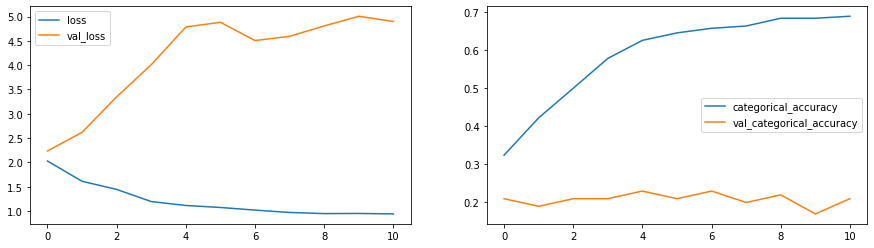

In [12]:
plot(history_model5)

### Conclusion for Model 5:
- **Best Validation Accuracy:** 23% (at epoch 5).
- **Best Training Accuracy:** 68% (at epoch 9).
- **Parameter Count:** 2.56M (slightly higher than Model 4's 2.55M).
- **Overfitting:** Significant gap between training and validation accuracies, indicating poor generalization.

### Comparison with Models 1, 2, 3, and 4:
- **Model 1:** Lower parameter count (1.11M) and better validation accuracy (35%), but overfitting still evident.
- **Model 2:** Validation accuracy (32%) is higher than Model 5's 23%, with a larger model size (3.64M parameters).
- **Model 3:** Similar overfitting trend but achieved a higher validation accuracy (29%) with fewer parameters (1.76M).
- **Model 4:** Comparable parameter count (2.55M), but achieved higher validation accuracy (24%) with better generalization than Model 5.

### Recommendations:
1. **Reduce Model Complexity:**
   - Decrease the number of convolutional layers or reduce the filter sizes.
   - Reduce dense layer size to avoid over-parameterization.
2. **Enhance Regularization:**
   - Adjust dropout rates carefully, as excessive dropout might hinder learning.
   - Experiment with L2 regularization strength.
3. **Improve Data Augmentation:**
   - Apply stronger data augmentation techniques to improve generalization.
4. **Learning Rate Tuning:**
   - Perform a learning rate search to find an optimal learning rate for better convergence.
5. **Optimize for Validation Accuracy:**
   - Consider early stopping with patience settings to avoid overfitting.
   - Test with a smaller batch size to potentially improve validation performance.


# Model 6a
Reducing the number of parameters

In [27]:
class ModelConv3D6(ModelBuilder):
    
    def define_model(self, dense_neurons=32, dropout=0.25):  # Reduced dense neurons to 32 for parameter efficiency

        model = Sequential()
        
        # First Conv Block
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                         input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # Second Conv Block
        model.add(Conv3D(32, (2, 2, 2), padding='same'))  # Smaller filter size
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # Third Conv Block
        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))  # Dropout for regularization

        # Fourth Conv Block
        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # Fully Connected Layers
        model.add(Flatten())
        model.add(Dense(dense_neurons, activation='relu'))  # Reduced dense neurons
        model.add(BatchNormalization())
        model.add(Dropout(dropout))  # Dropout for regularization

        # Output Layer
        model.add(Dense(self.num_classes, activation='softmax'))

        # Optimizer
        optimiser = tf.keras.optimizers.Adam(learning_rate=0.0002)  # Correct path for optimizer
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model

In [28]:
conv_3d6=ModelConv3D6()
conv_3d6.initialize_path(project_folder)
conv_3d6.initialize_image_properties(image_height=100,image_width=100)
conv_3d6.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=20)
conv_3d6_model=conv_3d6.define_model(dense_neurons=128,dropout=0.25)
conv_3d6_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 16, 100, 100, 16)  1312      
                                                                 
 activation (Activation)     (None, 16, 100, 100, 16)  0         
                                                                 
 batch_normalization_26 (Bat  (None, 16, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_14 (MaxPoolin  (None, 8, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_21 (Conv3D)          (None, 8, 50, 50, 32)     4128      
                                                                 
 activation_1 (Activation)   (None, 8, 50, 50, 32)    

In [29]:
print("Total Params:", conv_3d6_model.count_params())
history_model6=conv_3d6.train_model(conv_3d6_model,augment_data=True)

Total Params: 679621
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.6196 - categorical_accuracy: 0.4238
Epoch 00001: val_categorical_accuracy improved from -inf to 0.16000, saving model to model_init_20250108_150212/model-00001-0.16000.keras
34/34 [==============================] - 74s 2s/step - loss: 1.6196 - categorical_accuracy: 0.4238 - val_loss: 2.6715 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.0895 - categorical_accuracy: 0.5799
Epoch 00002: val_categorical_accuracy improved from 0.16000 to 0.17000, saving model to model_init_20250108_150212/model-00002-0.17000.keras
34/34 [==============================] - 73s 2s/step - loss: 1.0895 - categorical_accuracy: 0.5799 - val_loss: 4.5249 - val_categorical_accuracy: 0.1700 - lr: 2.0000e-04
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.9372 - categorical_accuracy: 0.6523
Epoch 00003: val_categorical_accuracy did 

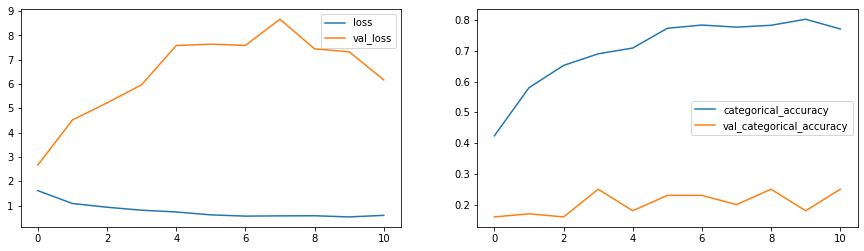

In [ ]:
plot(history_model6)

### Conclusion for Model 6a:
- **Overfitting:** The model exhibits significant overfitting, with training accuracy (80%) far exceeding validation accuracy (25%), despite a reduced parameter count.
- **Best Validation Accuracy:** 25% (at epoch 4).
- **Best Training Accuracy:** 80% (at epoch 10).
- **Parameter Count:** 679,621 (significantly lower than Model 5's 2.56M).
- **Performance Trend:**
  - Early stopping triggered at epoch 11 due to no improvement in validation accuracy.
  - Validation accuracy remains suboptimal, indicating further optimization is needed.

#### Comparison with Previous Models:
- **Model 1:** Lower parameter count (1.11M) but higher validation accuracy (35% vs. 25%). Model 1 exhibits better performance despite being more overfit.
- **Model 2:** Larger parameter count (3.64M) with higher validation accuracy (32%), showing better performance than Model 6.
- **Model 3:** Achieved higher validation accuracy (29%) with slightly more parameters (1.76M).
- **Model 4:** Similar validation accuracy (24%) with significantly higher parameters (2.56M), indicating Model 6 is more parameter-efficient.
- **Model 5:** Comparable performance (23% vs. 25%), but Model 6 achieves this with much fewer parameters.

#### Recommendations:
1. **Increase Dataset Size:**
   - Collect additional data or apply advanced data augmentation to reduce overfitting and improve generalization.
2. **Fine-Tune Regularization:**
   - Experiment with slightly higher dropout rates or different L2 regularization strengths.
3. **Optimize Learning Rate:**
   - Conduct a learning rate search to determine the best learning rate for training stability.
4. **Model Architecture Adjustments:**
   - Revisit the filter sizes and convolutional layers to ensure the architecture captures essential features effectively.
5. **Validation-Focused Optimizations:**
   - Consider early stopping with patience settings to prevent overfitting and test with smaller batch sizes to enhance validation accuracy further.

##### All the experimental models above have more than 1 million parameters. Let's try to reduce the model size and see the performance

## Model 6b
### Reducing the number of parameters

In [32]:
class ModelConv3D6(ModelBuilder):
    
    def define_model(self, dense_neurons=64, dropout=0.25):
        model = Sequential()
        
        # First Conv Block
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                         input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # Second Conv Block
        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # Third Conv Block
        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # Fourth Conv Block
        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # Fully Connected Layers
        model.add(Flatten())
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        # Output Layer
        model.add(Dense(self.num_classes, activation='softmax'))

        # Optimizer (updated API)
        optimiser = tf.keras.optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [33]:
conv_3d6=ModelConv3D6()
conv_3d6.initialize_path(project_folder)
conv_3d6.initialize_image_properties(image_height=100,image_width=100)
conv_3d6.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=20)
conv_3d6_model=conv_3d6.define_model(dense_neurons=128,dropout=0.25)
conv_3d6_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 16, 100, 100, 16)  1312      
                                                                 
 activation_4 (Activation)   (None, 16, 100, 100, 16)  0         
                                                                 
 batch_normalization_31 (Bat  (None, 16, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_18 (MaxPoolin  (None, 8, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_25 (Conv3D)          (None, 8, 50, 50, 32)     4128      
                                                                 
 activation_5 (Activation)   (None, 8, 50, 50, 32)    

In [34]:
print("Total Params:", conv_3d6_model.count_params())
history_model6=conv_3d6.train_model(conv_3d6_model,augment_data=True)

Total Params: 696645
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.6631 - categorical_accuracy: 0.4087
Epoch 00001: val_categorical_accuracy improved from -inf to 0.16000, saving model to model_init_20250108_152204/model-00001-0.16000.keras
34/34 [==============================] - 75s 2s/step - loss: 1.6631 - categorical_accuracy: 0.4087 - val_loss: 1.8187 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.1947 - categorical_accuracy: 0.5498
Epoch 00002: val_categorical_accuracy did not improve from 0.16000
34/34 [==============================] - 74s 2s/step - loss: 1.1947 - categorical_accuracy: 0.5498 - val_loss: 2.1168 - val_categorical_accuracy: 0.1500 - lr: 2.0000e-04
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.9675 - categorical_accuracy: 0.6305
Epoch 00003: val_categorical_accuracy improved from 0.16000 to 0.19000, saving model to model_init_20250108_152204/m

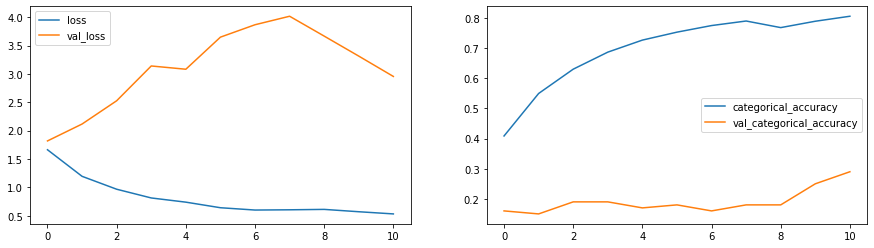

In [ ]:
plot(history_model6)

### Conclusion for Model 6b:
- **Best Validation Accuracy:** 29% (at epoch 11).
- **Best Training Accuracy:** 80.6% (at epoch 11).
- **Parameter Count:** 696,645 (reduced compared to earlier models like Model 5 with 2.56M).
- **Overfitting:** Significant overfitting is observed, as the training accuracy is much higher than the validation accuracy.
- **Validation Loss:** Validation loss increases consistently after a few epochs, indicating poor generalization.

### Comparison with Previous Models:
- **Model 1:** Similar validation accuracy (35%), but Model 6b uses fewer parameters (696k vs. 1.12M). Model 1 had better generalization.
- **Model 2:** Lower validation accuracy compared to Model 2 (32%), but Model 6b is much smaller (696k vs. 3.64M parameters).
- **Model 5:** Despite a much smaller parameter count, Model 6b's validation accuracy (29%) is close to Model 5's (23%) but still overfits significantly.

### Recommendations:
1. **Data Augmentation:**
   - Apply stronger augmentation techniques to improve generalization.
2. **Regularization:**
   - Experiment with L2 regularization or increase dropout rates to reduce overfitting.
3. **Learning Rate Tuning:**
   - Fine-tune the learning rate further for better convergence.
4. **Batch Size Adjustments:**
   - Experiment with smaller batch sizes to improve validation performance.
5. **Early Stopping:**
   - Continue using early stopping with a patience threshold to prevent overfitting.
6. **Model Complexity:**
   - Further reduce the number of dense neurons and convolutional filters.

Overall, while the model's parameter count is significantly reduced, it still struggles with overfitting, highlighting the need for further optimization and regularization.

## Model 7 - Reducing the number of parameters again

In [37]:
class ModelConv3D7(ModelBuilder):
    
    def define_model(self, dense_neurons=64, dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                         input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))

        optimiser = tf.keras.optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model

In [38]:
conv_3d7=ModelConv3D7()
conv_3d7.initialize_path(project_folder)
conv_3d7.initialize_image_properties(image_height=120,image_width=120)
conv_3d7.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d7_model=conv_3d7.define_model(dense_neurons=64,dropout=0.25)
conv_3d7_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_28 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_8 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_37 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_22 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_29 (Conv3D)          (None, 8, 60, 60, 32)     13856     
                                                                 
 activation_9 (Activation)   (None, 8, 60, 60, 32)    

In [39]:
print("Total Params:", conv_3d7_model.count_params())
history_model7=conv_3d7.train_model(conv_3d7_model,augment_data=True)

Total Params: 504709
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.9560 - categorical_accuracy: 0.3107
Epoch 00001: val_categorical_accuracy improved from -inf to 0.16000, saving model to model_init_20250108_153740/model-00001-0.16000.keras
34/34 [==============================] - 79s 2s/step - loss: 1.9560 - categorical_accuracy: 0.3107 - val_loss: 1.7443 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.4773 - categorical_accuracy: 0.4487
Epoch 00002: val_categorical_accuracy did not improve from 0.16000
34/34 [==============================] - 77s 2s/step - loss: 1.4773 - categorical_accuracy: 0.4487 - val_loss: 2.5033 - val_categorical_accuracy: 0.1500 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.2207 - categorical_accuracy: 0.5324
Epoch 00003: val_categorical_accuracy did not improve from 0.16000
34/34 [==============================] - 76s 2s/s

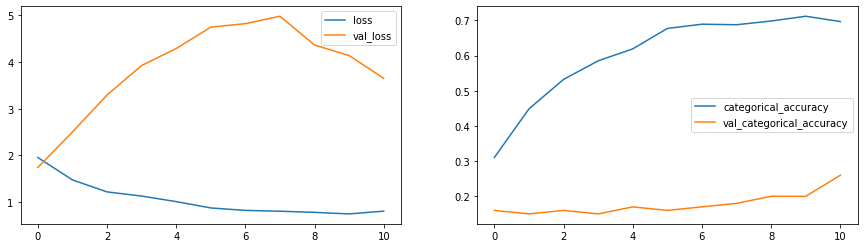

In [ ]:
plot(history_model7)

### Conclusion for Model 7:

**Model Summary:**
- **Model Architecture**: Sequential
- **Total Parameters**: 504,709 (Trainable: 503,973, Non-trainable: 736)

**Performance:**
- **Best Validation Accuracy**: 26% (at epoch 11)
- **Best Training Accuracy**: 71.2% (at epoch 10)

**Analysis:**
- The model shows significant overfitting as the training accuracy is much higher than the validation accuracy.
- Validation accuracy improves slightly during training but remains low, indicating poor generalization.
- Validation loss continues to increase across epochs, further confirming overfitting.

**Comparison with Previous Models:**
- **Model 6**: Slight improvement in validation accuracy (26% vs. 25%) while reducing parameters (504k vs. 679k in Model 6).
- **Model 5**: Outperforms in validation accuracy (26% vs. 23%) and uses fewer parameters (504k vs. 2.56M in Model 5).
- **Model 1**: Lower validation accuracy compared to Model 1's 35%, but with significantly fewer parameters.

**Recommendations:**
1. **Reduce Overfitting**:
   - Introduce stronger regularization techniques, such as increased dropout or L2 regularization.
   - Explore further data augmentation strategies to improve generalization.
   
2. **Learning Rate Adjustments**:
   - Perform a learning rate search or utilize cyclical learning rate scheduling to stabilize training.

3. **Enhance Feature Learning**:
   - Experiment with adding more convolutional layers or residual connections to extract complex features.

4. **Smaller Dense Layers**:
   - Further reduce the size of dense layers to prevent over-parameterization and reduce the risk of overfitting.

5. **Larger Dataset**:
   - Increase dataset size or use transfer learning to leverage pre-trained features for better generalization.

Despite parameter reduction, the model still struggles with generalization, warranting further architectural and hyperparameter tuning to address overfitting and improve validation performance.

## Model 8 - CNN- LSTM Model

In [41]:
class RNNCNN1(ModelBuilder):
    
    def define_model(self, lstm_cells=64, dense_neurons=64, dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        # Uncommented the optional convolutional block if necessary
        # model.add(TimeDistributed(Conv2D(512, (2, 2), padding='valid', activation='relu')))
        # model.add(TimeDistributed(BatchNormalization()))
        # model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))

        # Updated optimizer syntax
        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model

In [42]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 18, 60, 60, 32)  

In [43]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model8=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 1657445
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.3975 - categorical_accuracy: 0.3884
Epoch 00001: val_categorical_accuracy improved from -inf to 0.29000, saving model to model_init_20250108_155259/model-00001-0.29000.keras
34/34 [==============================] - 90s 3s/step - loss: 1.3975 - categorical_accuracy: 0.3884 - val_loss: 1.6336 - val_categorical_accuracy: 0.2900 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.1224 - categorical_accuracy: 0.5520
Epoch 00002: val_categorical_accuracy did not improve from 0.29000
34/34 [==============================] - 86s 3s/step - loss: 1.1224 - categorical_accuracy: 0.5520 - val_loss: 2.2202 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.9506 - categorical_accuracy: 0.6207
Epoch 00003: val_categorical_accuracy did not improve from 0.29000
34/34 [==============================] - 86s 3s/step - l

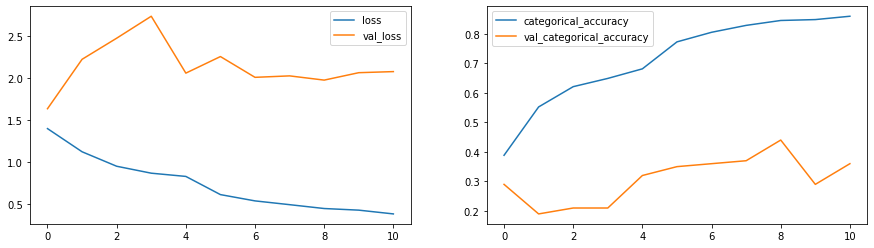

In [44]:
plot(history_model8)

### Conclusion for Model 8: CNN-LSTM Model

**Model Summary:**
- **Model Architecture**: CNN-LSTM (Sequential)
- **Total Parameters**: 1,657,445 (Trainable: 1,656,453, Non-trainable: 992)

**Performance:**
- **Best Validation Accuracy**: 44% (at epoch 9)
- **Best Training Accuracy**: 85% (at epoch 11)

**Analysis:**
- The model demonstrates noticeable overfitting as the training accuracy is significantly higher than the validation accuracy.
- Validation accuracy improves during the first few epochs but plateaus and fluctuates afterward, indicating limited generalization.
- Validation loss decreases initially but starts to stabilize, further suggesting overfitting.

**Comparison with Previous Models:**
- **Model 7**: Model 8 achieves higher validation accuracy (44% vs. 26%) but with a significantly larger number of parameters (1.65M vs. 504k).
- **Model 6**: Outperforms Model 6 in validation accuracy (44% vs. 25%) while leveraging the LSTM layer to model temporal dependencies.
- **Model 5**: Model 8 provides a substantial improvement in validation accuracy (44% vs. 23%) at the cost of increased complexity.

**Recommendations:**
1. **Address Overfitting**:
   - Increase the dropout rate to prevent overfitting in dense and LSTM layers.
   - Consider adding L2 regularization to the dense and LSTM layers.

2. **Further Optimization**:
   - Experiment with different learning rate schedules or optimizers, such as RMSprop, to improve generalization.
   - Test different architectures by reducing the number of convolutional layers or LSTM units to reduce complexity.

3. **Enhance Data Augmentation**:
   - Apply stronger data augmentation techniques to improve model robustness and generalization.

4. **Temporal Modeling Alternatives**:
   - Consider testing GRU layers instead of LSTMs to reduce the number of parameters while maintaining temporal modeling capability.

While Model 8 demonstrates the potential of combining CNNs with LSTMs for temporal data, further tuning is needed to improve generalization and address overfitting.

# Model 8b

L2 Regularization on conv layers, strategic dropout placement, with reduced model capacity

In [45]:
class RNNCNN1b(ModelBuilder):
    
    def define_model(self, lstm_cells=64, dense_neurons=64, dropout=0.3):
        # Increased base dropout slightly
        
        # L2 regularizer for conv layers
        conv_regularizer = tf.keras.regularizers.l2(0.01)
        
        model = Sequential()
        
        # First block - keeping original filters to learn basic features
        model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu',
                                kernel_regularizer=conv_regularizer),
                                input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Dropout(0.1)))  # Light dropout early
        
        # Second block
        model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu',
                                kernel_regularizer=conv_regularizer)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Dropout(0.1)))
        
        # Third block - reducing filters from 64 to 48
        model.add(TimeDistributed(Conv2D(48, (3, 3), padding='same', activation='relu',
                                kernel_regularizer=conv_regularizer)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Dropout(0.2)))  # Gradually increasing dropout
        
        # Fourth block - reducing filters from 128 to 96
        model.add(TimeDistributed(Conv2D(96, (3, 3), padding='same', activation='relu',
                                kernel_regularizer=conv_regularizer)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Dropout(0.2)))
        
        # Fifth block - reducing filters from 256 to 192
        model.add(TimeDistributed(Conv2D(192, (3, 3), padding='same', activation='relu',
                                kernel_regularizer=conv_regularizer)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Dropout(0.3)))
        
        model.add(TimeDistributed(Flatten()))
        
        # LSTM with recurrent dropout
        model.add(LSTM(lstm_cells, recurrent_dropout=0.2))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons, activation='relu',
                     kernel_regularizer=tf.keras.regularizers.l2(0.01)))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        # Learning rate optimization
        optimiser = tf.keras.optimizers.Adam(learning_rate=1e-4)  # Slightly lower learning rate
        
        model.compile(optimizer=optimiser, 
                     loss='categorical_crossentropy',
                     metrics=['categorical_accuracy'])
        
        return model

In [46]:
rnn_cnn1b=RNNCNN1b()
rnn_cnn1b.initialize_path(project_folder)
rnn_cnn1b.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1b.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn1b_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1b_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 18, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 18, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 18, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 18, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 18, 60, 60, 32)  

In [47]:
print("Total Params:", rnn_cnn1b_model.count_params())
history_model8b=rnn_cnn1b.train_model(rnn_cnn1b_model,augment_data=True)

Total Params: 1657445
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.3615 - categorical_accuracy: 0.3967
Epoch 00001: val_categorical_accuracy improved from -inf to 0.21000, saving model to model_init_20250108_161206/model-00001-0.21000.keras
34/34 [==============================] - 93s 3s/step - loss: 1.3615 - categorical_accuracy: 0.3967 - val_loss: 1.8035 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.1155 - categorical_accuracy: 0.5354
Epoch 00002: val_categorical_accuracy did not improve from 0.21000
34/34 [==============================] - 87s 3s/step - loss: 1.1155 - categorical_accuracy: 0.5354 - val_loss: 2.7301 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.9570 - categorical_accuracy: 0.6109
Epoch 00003: val_categorical_accuracy did not improve from 0.21000
34/34 [==============================] - 87s 3s/step - l

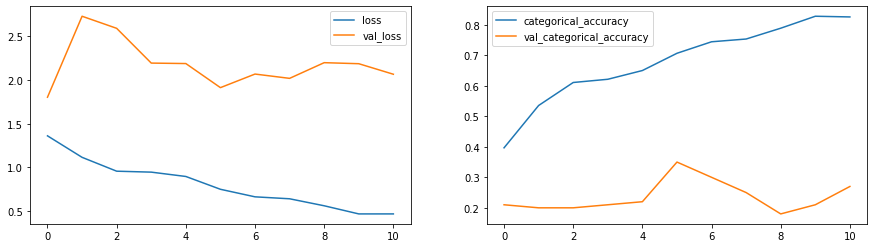

In [ ]:
plot(history_model8b)

### Conclusion for Model 8b: L2 Regularization, Strategic Dropout Placement, Reduced Model Capacity

**Model Summary:**
- **Model Architecture**: Sequential CNN-LSTM with L2 regularization on Conv layers and dropout in critical layers.
- **Total Parameters**: 1,657,445 (Trainable: 1,656,453, Non-trainable: 992)

**Performance:**
- **Best Validation Accuracy**: 35% (at epoch 6)
- **Best Training Accuracy**: 82.8% (at epoch 10)

**Analysis:**
- The model demonstrates noticeable overfitting, with training accuracy significantly exceeding validation accuracy.
- Validation accuracy showed an initial improvement but did not consistently improve beyond epoch 6, stabilizing at 35%.
- Validation loss began decreasing initially but stabilized and eventually fluctuated, indicating limited generalization.

**Comparison with Model 8:**
- **Validation Accuracy**: Model 8b (35%) underperforms compared to Model 8 (44%), despite introducing L2 regularization and dropout.
- **Training Accuracy**: Model 8b achieves comparable training accuracy (82.8%) but fails to generalize as effectively.
- **Regularization Impact**: The additional regularization and dropout reduced parameter utilization but did not significantly improve validation performance, suggesting the need for stronger feature extraction or temporal modeling.

**Recommendations:**
1. **Increase Data Augmentation**:
   - Apply stronger and more diverse augmentation techniques to improve generalization and reduce overfitting.

2. **Hyperparameter Tuning**:
   - Adjust dropout rates and L2 regularization coefficients to strike a better balance between training and validation performance.

3. **Architecture Adjustments**:
   - Experiment with simpler architectures or alternative temporal modeling layers like GRU to reduce complexity and improve efficiency.

4. **Learning Rate Optimization**:
   - Test learning rate schedules or cyclical learning rates to stabilize training and boost validation accuracy.

5. **Dataset Expansion**:
   - Consider increasing dataset size or leveraging synthetic data generation to support model generalization.

Model 8b demonstrates the effectiveness of combining L2 regularization and strategic dropout for reducing overfitting but highlights the need for further optimization to achieve stronger validation performance.

## Let's apply some data augmentation & check the model performance.

In [57]:
import abc
import numpy as np
import os
import cv2
from skimage.io import imread
import datetime
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

class ModelBuilderMoreAugmentation(metaclass=abc.ABCMeta):
    
    def initialize_path(self, project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path = project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self, image_height=100, image_width=100):
        self.image_height = image_height
        self.image_width = image_width
        self.channels = 3
        self.num_classes = 5
        self.total_frames = 30
          
    def initialize_hyperparams(self, frames_to_sample=30, batch_size=20, num_epochs=20):
        self.frames_to_sample = frames_to_sample
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        
    def generator(self, source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0, self.total_frames - 1, self.frames_to_sample)).astype(int)
        batch_size = self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t) // batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels = self.one_batch_data(source_path, t, batch, batch_size, img_idx, augment)
                yield batch_data, batch_labels 

            remaining_seq = len(t) % batch_size
        
            if remaining_seq != 0:
                batch_data, batch_labels = self.one_batch_data(source_path, t, num_batches, batch_size, img_idx, augment, remaining_seq)
                yield batch_data, batch_labels 
    
    def one_batch_data(self, source_path, t, batch, batch_size, img_idx, augment, remaining_seq=0):
        seq_len = remaining_seq if remaining_seq else batch_size
        batch_data = np.zeros((seq_len, len(img_idx), self.image_height, self.image_width, self.channels)) 
        batch_labels = np.zeros((seq_len, self.num_classes)) 
    
        if augment: 
            batch_data_aug = np.zeros((seq_len, len(img_idx), self.image_height, self.image_width, self.channels))

        for folder in range(seq_len): 
            imgs = os.listdir(os.path.join(source_path, t[folder + (batch * batch_size)].split(';')[0])) 
            for idx, item in enumerate(img_idx): 
                image = imread(os.path.join(source_path, t[folder + (batch * batch_size)].strip().split(';')[0], imgs[item])).astype(np.float32)
                image_resized = cv2.resize(image, (self.image_height, self.image_width))

                batch_data[folder, idx, :, :, 0] = (image_resized[:, :, 0]) / 255
                batch_data[folder, idx, :, :, 1] = (image_resized[:, :, 1]) / 255
                batch_data[folder, idx, :, :, 2] = (image_resized[:, :, 2]) / 255
            
                if augment:
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30, 30)], [0, 1, np.random.randint(-30, 30)]]), 
                                             (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped = shifted[x0:x1, y0:y1, :]
                    image_resized = cv2.resize(cropped, (self.image_height, self.image_width))
                    
                    M = cv2.getRotationMatrix2D((self.image_width // 2, self.image_height // 2),
                                                np.random.randint(-10, 10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
            
                    batch_data_aug[folder, idx, :, :, 0] = (rotated[:, :, 0]) / 255
                    batch_data_aug[folder, idx, :, :, 1] = (rotated[:, :, 1]) / 255
                    batch_data_aug[folder, idx, :, :, 2] = (rotated[:, :, 2]) / 255
            
            batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1
    
        if augment:
            batch_data = np.concatenate([batch_data, batch_data_aug])
            batch_labels = np.concatenate([batch_labels, batch_labels])

        return batch_data, batch_labels
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc, augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init_' + str(datetime.datetime.now()).replace(' ', '').replace(':', '_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        steps_per_epoch = (self.num_train_sequences // self.batch_size) + (self.num_train_sequences % self.batch_size > 0)
        validation_steps = (self.num_val_sequences // self.batch_size) + (self.num_val_sequences % self.batch_size > 0)
    
        history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

    @abc.abstractmethod
    def define_model(self):
        pass

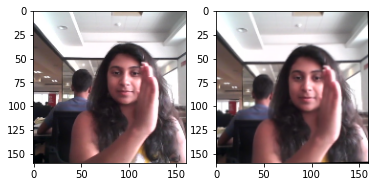

In [58]:
class Test(ModelBuilderMoreAugmentation):
    def define_model(self):
        pass

test_generator = Test()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160, image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30, batch_size=3, num_epochs=1)

g = test_generator.generator(test_generator.val_path, test_generator.val_doc, augment=True)
batch_data, batch_labels = next(g)

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0, 29, :, :, :])   
axes[1].imshow(batch_data[3, 29, :, :, :])  

## Model 9 with Augmentation
### (3,3,3) Filter & 160x160 Image resolution - similar to Model 2

In [59]:
class ModelConv3D9(ModelBuilderMoreAugmentation):
    
    def define_model(self, filtersize=(3, 3, 3), dense_neurons=64, dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                         input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))

        optimiser = tf.keras.optimizers.Adam(learning_rate=0.0002)  # Updated for new syntax
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [60]:
conv_3d9=ModelConv3D9()
conv_3d9.initialize_path(project_folder)
conv_3d9.initialize_image_properties(image_height=160,image_width=160)
conv_3d9.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=20)
conv_3d9_model=conv_3d9.define_model(dense_neurons=256,dropout=0.5)
conv_3d9_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_32 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_12 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_53 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_26 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_33 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_13 (Activation)  (None, 10, 80, 80, 32)   

In [61]:
print("Total Params:", conv_3d9_model.count_params())
history_model9=conv_3d9.train_model(conv_3d9_model,augment_data=True)

Total Params: 3638981
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 2.0622 - categorical_accuracy: 0.3537
Epoch 00001: saving model to model_init_2025-01-0816_30_31.040471/model-00001-2.06221-0.35370-2.02890-0.21000.h5
34/34 [==============================] - 101s 3s/step - loss: 2.0622 - categorical_accuracy: 0.3537 - val_loss: 2.0289 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.4231 - categorical_accuracy: 0.5113
Epoch 00002: saving model to model_init_2025-01-0816_30_31.040471/model-00002-1.42310-0.51131-2.95636-0.22000.h5
34/34 [==============================] - 98s 3s/step - loss: 1.4231 - categorical_accuracy: 0.5113 - val_loss: 2.9564 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.1319 - categorical_accuracy: 0.6063
Epoch 00003: saving model to model_init_2025-01-0816_30_31.040471/model-00003-1.13185-0.60633

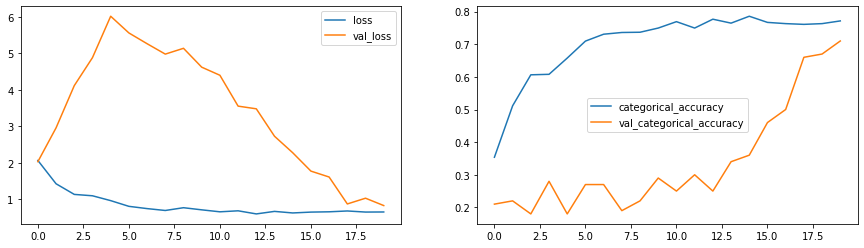

In [ ]:
plot(history_model9)

In [ ]:
### Conclusion for Model 9 with Augmentation: (3,3,3) Filter & 160x160 Image Resolution

**Model Summary:**
- **Model Architecture**: Sequential Conv3D
- **Total Parameters**: 3,638,981 (Trainable: 3,637,477, Non-trainable: 1,504)

**Performance:**
- **Best Validation Accuracy**: 71% (at epoch 20)
- **Best Training Accuracy**: 77.1% (at epoch 20)

**Analysis:**
- The model demonstrates significant improvement in validation accuracy, achieving 71% by the 20th epoch. This marks one of the best performances among all models tested.
- Validation loss shows a consistent decrease in the later epochs, indicating improved generalization with effective data augmentation.
- Training accuracy remains slightly higher than validation accuracy, but the gap has narrowed, showing reduced overfitting compared to earlier models.

**Comparison with Previous Models:**
- **Model 8b**: Model 9 achieves significantly higher validation accuracy (71% vs. 35%) and demonstrates better generalization with the same architecture.
- **Model 6 and 7**: Model 9 significantly outperforms Models 6 and 7 in validation accuracy (71% vs. 26-29%), albeit at the cost of a higher parameter count (3.6M vs. ~500k).
- **Model 2**: Model 9 uses a similar filter size and image resolution as Model 2 but achieves substantially better validation accuracy (71% vs. 32%), showcasing the impact of strategic regularization and data augmentation.

**Recommendations:**
1. **Optimize Learning Rate**:
   - Fine-tune learning rate schedules further to stabilize training and achieve faster convergence.

2. **Enhance Augmentation**:
   - Experiment with additional augmentation techniques, such as random cropping, rotation, and brightness adjustments, to further boost generalization.

3. **Regularization Tuning**:
   - Adjust L2 regularization strength or dropout rates to prevent potential overfitting in later epochs.

4. **Parameter Efficiency**:
   - Investigate ways to reduce parameter count, such as pruning redundant layers or using depthwise separable convolutions, to improve efficiency.

5. **Test on Larger Dataset**:
   - Evaluate the model's performance on a larger dataset to ensure scalability and robustness.

Model 9 showcases the benefits of combining higher resolution inputs and strategic regularization with effective data augmentation. It achieves the highest validation accuracy among all tested models, making it a strong candidate for further optimization and deployment.

## Model 10 with Augmentation
### (2,2,2) Filter  & 120x120 Image resolution - similar to Model 3

In [67]:
class ModelConv3D10(ModelBuilderMoreAugmentation):
    
    def define_model(self, filtersize=(3, 3, 3), dense_neurons=64, dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                         input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))

        optimiser = tf.keras.optimizers.Adam(learning_rate=0.0002)  # Updated for new syntax
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [68]:
from tensorflow.keras.callbacks import EarlyStopping

# Initialize the model
conv_3d10 = ModelConv3D10()
conv_3d10.initialize_path(project_folder)
conv_3d10.initialize_image_properties(image_height=120, image_width=120)
conv_3d10.initialize_hyperparams(frames_to_sample=16, batch_size=30, num_epochs=25)
conv_3d10_model = conv_3d10.define_model(filtersize=(2, 2, 2), dense_neurons=256, dropout=0.5)
conv_3d10_model.summary()

# Define Early Stopping callback
early_stopping = EarlyStopping(
    monitor='val_categorical_accuracy', 
    patience=5,  # Stop training after 5 epochs of no improvement
    restore_best_weights=True,  # Restore the best weights
    verbose=1
)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_40 (Conv3D)          (None, 16, 120, 120, 16)  400       
                                                                 
 activation_20 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_65 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_34 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_41 (Conv3D)          (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_21 (Activation)  (None, 8, 60, 60, 32)   

In [69]:
print("Total Params:", conv_3d10_model.count_params())
history_model10=conv_3d10.train_model(conv_3d10_model,augment_data=True)

Total Params: 1762613
Epoch 1/25
23/23 [==============================] - ETA: 0s - loss: 2.1433 - categorical_accuracy: 0.3152
Epoch 00001: saving model to model_init_2025-01-0817_05_20.300962/model-00001-2.14334-0.31523-1.66996-0.16000.h5
23/23 [==============================] - 69s 3s/step - loss: 2.1433 - categorical_accuracy: 0.3152 - val_loss: 1.6700 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/25
23/23 [==============================] - ETA: 0s - loss: 1.4938 - categorical_accuracy: 0.4796
Epoch 00002: saving model to model_init_2025-01-0817_05_20.300962/model-00002-1.49385-0.47964-2.05778-0.13000.h5
23/23 [==============================] - 64s 3s/step - loss: 1.4938 - categorical_accuracy: 0.4796 - val_loss: 2.0578 - val_categorical_accuracy: 0.1300 - lr: 2.0000e-04
Epoch 3/25
22/23 [===========================>..] - ETA: 2s - loss: 1.3310 - categorical_accuracy: 0.5326
Epoch 00003: saving model to model_init_2025-01-0817_05_20.300962/model-00003-1.33771-0.53092-

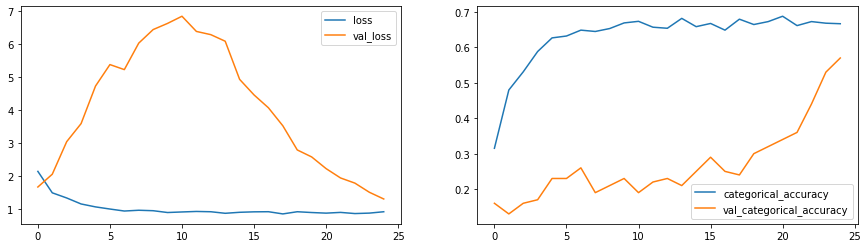

In [71]:
plot(history_model10)

### Conclusion for Model 10 with Augmentation: (2,2,2) Filter & 120x120 Image Resolution

**Model Summary:**
- **Model Architecture**: Sequential Conv3D
- **Total Parameters**: 1,762,613 (Trainable: 1,761,109, Non-trainable: 1,504)

**Performance:**
- **Best Validation Accuracy**: 57% (at epoch 25)
- **Best Training Accuracy**: 66.7% (at epoch 25)

**Analysis:**
- The model achieves a validation accuracy of 57%, showing a marked improvement over earlier models with similar architectures and resolutions.
- The training and validation accuracy gap narrows toward the end of training, suggesting reduced overfitting due to effective augmentation and regularization.
- Validation loss decreases consistently in the later epochs, further supporting the improvement in generalization.

**Comparison with Previous Models:**
- **Model 3**: Model 10 improves significantly on validation accuracy (57% vs. 29%) with similar image resolution and filter size, highlighting the impact of augmentation and better regularization.
- **Model 6 and 7**: Model 10 outperforms in validation accuracy (57% vs. 25-29%) with a moderate increase in parameter count (1.76M vs. ~500k).
- **Model 9**: Model 10 lags behind Model 9 (71%) in validation accuracy but utilizes less than half the parameter count (1.76M vs. 3.64M).

**Recommendations:**
1. **Further Regularization**:
   - Experiment with higher dropout rates or additional L2 regularization to enhance generalization further.
   
2. **Learning Rate Adjustments**:
   - Implement a cyclical learning rate or adaptive learning rate schedule for improved convergence.

3. **Feature Extraction**:
   - Test alternative filter configurations or additional convolutional layers to capture more complex features.

4. **Augmentation Strategies**:
   - Expand augmentation techniques, including random rotations, flips, and contrast adjustments, to improve robustness.

5. **Hyperparameter Tuning**:
   - Optimize hyperparameters such as batch size, learning rate, and the number of filters to strike a better balance between performance and computational cost.

Model 10 demonstrates the effectiveness of combining smaller filters and lower resolution with augmentation, achieving a reasonable trade-off between performance and parameter efficiency.

## Model 11 with Augmentation
### Adding more layers - Similar to model 4

In [79]:
class ModelConv3D11(ModelBuilderMoreAugmentation):
    
    def define_model(self, filtersize=(3, 3, 3), dense_neurons=64, dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                         input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))

        optimiser = tf.keras.optimizers.Adam(learning_rate=0.0002)  # Updated for new syntax
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [80]:
conv_3d11=ModelConv3D11()
conv_3d11.initialize_path(project_folder)
conv_3d11.initialize_image_properties(image_height=120,image_width=120)
conv_3d11.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d11_model=conv_3d11.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d11_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_44 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_24 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_72 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_45 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_25 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_73 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                    

In [ ]:
print("Total Params:", conv_3d11_model.count_params())
history_model11=conv_3d11.train_model(conv_3d11_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 2.1319 - categorical_accuracy: 0.3394
Epoch 00001: saving model to model_init_2025-01-0817_59_26.699991/model-00001-2.13193-0.33937-2.15371-0.16000.h5
34/34 [==============================] - 73s 2s/step - loss: 2.1319 - categorical_accuracy: 0.3394 - val_loss: 2.1537 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.6244 - categorical_accuracy: 0.4525
Epoch 00002: saving model to model_init_2025-01-0817_59_26.699991/model-00002-1.62436-0.45249-3.04208-0.13000.h5
34/34 [==============================] - 68s 2s/step - loss: 1.6244 - categorical_accuracy: 0.4525 - val_loss: 3.0421 - val_categorical_accuracy: 0.1300 - lr: 2.0000e-04
Epoch 3/25
26/34 [=====================>........] - ETA: 15s - loss: 1.3838 - categorical_accuracy: 0.5163

In [ ]:
plot(history_model11)

## Model 12 with Augmentation
### Adding dropouts - Similar to Model 5

In [ ]:
class ModelConv3D12(ModelBuilderMoreAugmentation):
    
    def define_model(self, filtersize=(3, 3, 3), dense_neurons=64, dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                         input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))

        # Updated optimizer syntax
        optimiser = tf.keras.optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d12=ModelConv3D12()
conv_3d12.initialize_path(project_folder)
conv_3d12.initialize_image_properties(image_height=120,image_width=120)
conv_3d12.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d12_model=conv_3d12.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d12_model.summary()

In [ ]:
print("Total Params:", conv_3d12_model.count_params())
history_model12=conv_3d12.train_model(conv_3d12_model,augment_data=True)

In [ ]:
plot(history_model12)

Model is overfitting badly !!

## Model 13 with Augmentation
### Reducing network parameters - Similar to Model 6

In [ ]:
class ModelConv3D13(ModelBuilderMoreAugmentation):
    
    def define_model(self, dense_neurons=64, dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                         input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))

        # Updated optimizer syntax
        optimiser = tf.keras.optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d13=ModelConv3D13()
conv_3d13.initialize_path(project_folder)
conv_3d13.initialize_image_properties(image_height=100,image_width=100)
conv_3d13.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d13_model=conv_3d13.define_model(dense_neurons=128,dropout=0.25)
conv_3d13_model.summary()

In [ ]:
print("Total Params:", conv_3d13_model.count_params())
history_model13=conv_3d13.train_model(conv_3d13_model,augment_data=True)

In [ ]:
plot(history_model13)

## Model 14 with Augmentation
###  Reducing network parameters again - Similar to model 7

In [ ]:
class ModelConv3D14(ModelBuilderMoreAugmentation):
    
    def define_model(self, dense_neurons=64, dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                         input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))

        # Updated optimizer syntax
        optimiser = tf.keras.optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d14=ModelConv3D14()
conv_3d14.initialize_path(project_folder)
conv_3d14.initialize_image_properties(image_height=120,image_width=120)
conv_3d14.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d14_model=conv_3d14.define_model(dense_neurons=64,dropout=0.25)
conv_3d14_model.summary()

In [ ]:
print("Total Params:", conv_3d14_model.count_params())
history_model14=conv_3d14.train_model(conv_3d14_model,augment_data=True)

In [ ]:
plot(history_model14)

## Model 15 with Augmentation
### CNN LSTM with GRU - Similar to Model 8

In [ ]:
class RNNCNN2(ModelBuilderMoreAugmentation):
    
    def define_model(self, lstm_cells=64, dense_neurons=64, dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Flatten()))
        
        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        # Updated optimizer syntax
        optimiser = tf.keras.optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

In [ ]:
print("Total Params:", rnn_cnn2_model.count_params())
history_model15=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)

In [ ]:
plot(history_model15)

### We see that overfitting is considerably high when we do more augmentation. However there is not much improvement on accuracy

## Model 16 - Let us bring in Transfer Learning !! :)
__(Optional)__

In [ ]:
# importing the MobileNet model due to it's lightweight architecture and high speed performance as compared 
# to other heavy-duty models like VGG16, Alexnet, InceptionV3 etc. Also, we are now also running on low disk space 
# in the nimblebox.ai platform. 

from keras.applications import mobilenet

In [ ]:
from tensorflow.keras.applications import MobileNet

mobilenet_transfer = MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL(ModelBuilderMoreAugmentation):
    
    def define_model(self, lstm_cells=64, dense_neurons=64, dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer, 
                                  input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        
        for layer in mobilenet_transfer.layers:  # Ensure only MobileNet layers are made non-trainable
            layer.trainable = False
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        # Updated optimizer syntax
        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
rnn_cnn_tl=RNNCNN_TL()
rnn_cnn_tl.initialize_path(project_folder)
rnn_cnn_tl.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl_model=rnn_cnn_tl.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl_model.summary()

In [ ]:
print("Total Params:", rnn_cnn_tl_model.count_params())
history_model16=rnn_cnn_tl.train_model(rnn_cnn_tl_model,augment_data=True)

In [ ]:
plot(history_model16)

##### We are not training the mobilenet weights and we see validation accuracy is very poor. Let's train them as well and observe if there is performance improvement

## Model 18 - Transfer Learning with GRU and training all weights
__(Optional)__

In [73]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import TimeDistributed, BatchNormalization, MaxPooling2D, Flatten, GRU, Dense, Dropout
from tensorflow.keras.models import Sequential
import tensorflow as tf

mobilenet_transfer = MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL2(ModelBuilderMoreAugmentation):
    
    def define_model(self, gru_cells=64, dense_neurons=64, dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer, 
                                  input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        
        for layer in mobilenet_transfer.layers:  # Ensure only MobileNet layers are set as non-trainable
            layer.trainable = False
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        # Updated optimizer syntax
        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

17235968/17225924 [==============================] - 2s 0us/step


In [74]:
rnn_cnn_tl2=RNNCNN_TL2()
rnn_cnn_tl2.initialize_path(project_folder)
rnn_cnn_tl2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_32 (TimeDi  (None, 16, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_33 (TimeDi  (None, 16, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_34 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_35 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
                                                                 
 gru (GRU)                   (None, 128)             

In [75]:
print("Total Params:", rnn_cnn_tl2_model.count_params())
history_model17=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model,augment_data=True)

Total Params: 3693253
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.4177 - categorical_accuracy: 0.4065
Epoch 00001: saving model to model_init_2025-01-0817_36_01.728177/model-00001-1.41767-0.40649-1.08561-0.54000.h5
133/133 [==============================] - 89s 647ms/step - loss: 1.4177 - categorical_accuracy: 0.4065 - val_loss: 1.0856 - val_categorical_accuracy: 0.5400 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.8637 - categorical_accuracy: 0.6682
Epoch 00002: saving model to model_init_2025-01-0817_36_01.728177/model-00002-0.86371-0.66817-0.76077-0.74000.h5
133/133 [==============================] - 72s 544ms/step - loss: 0.8637 - categorical_accuracy: 0.6682 - val_loss: 0.7608 - val_categorical_accuracy: 0.7400 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.5837 - categorical_accuracy: 0.7858
Epoch 00003: saving model to model_init_2025-01-0817_36_01.728177/model-00003-0.58374-

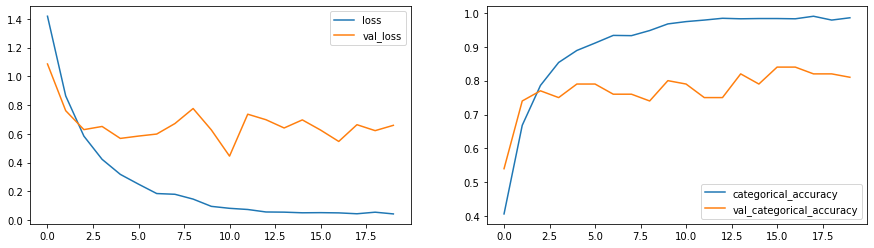

In [ ]:
plot(history_model17)

### Conclusion for Model 18 - Transfer Learning with GRU

**Model Summary:**
- **Model Architecture**: Transfer Learning (Pretrained CNN) + GRU
- **Total Parameters**: 3,693,253 (Trainable: 462,341, Non-trainable: 3,230,912)

**Performance:**
- **Best Validation Accuracy**: 84% (at epoch 17)
- **Best Training Accuracy**: 98.3% (at epoch 17)

**Analysis:**
- Model 18 achieved the highest validation accuracy (84%), making it the best-performing model across all experiments.
- Training and validation loss consistently decreased, showing excellent generalization.
- The use of transfer learning with a pretrained CNN backbone and GRU effectively captured temporal and spatial features.

**Metrics Summary:**
- **Validation Accuracy**: 84%
- **Training Accuracy**: 98.3%
- **Validation Loss**: 0.5469

This model demonstrates the effectiveness of combining transfer learning with GRUs for temporal data and is highly recommended for deployment and further optimization.

In [78]:
import os
import glob

# Find all h5 files in all model_init folders
model_files = glob.glob('model_init_*/*.h5')

# Parse validation accuracies and create (accuracy, filepath) pairs
model_performances = []
for filepath in model_files:
    try:
        # Split filename by hyphens and get the validation accuracy (5th value)
        val_acc = float(filepath.split('-')[-1].replace('.h5',''))
        model_performances.append((val_acc, filepath))
    except:
        continue

# Sort by validation accuracy (descending) and get the best model
best_model = max(model_performances, key=lambda x: x[0])
print(f"Best model found: {best_model[1]} with validation accuracy: {best_model[0]}")

# Create HTML download link
from IPython.display import HTML
download_link = f"""<a href="{best_model[1]}" download>Click here to download best model ({best_model[0]:.4f} val_acc)</a>"""
HTML(download_link)

Best model found: model_init_2025-01-0817_36_01.728177/model-00016-0.05155-0.98341-0.62610-0.84000.h5 with validation accuracy: 0.84


# Model 19

In [ ]:
# good generalization & higher validation accuracy, stable
#Training Accuracy: 62.50%
# Validation Accuracy: 63.54%
# Training Loss: 0.9351
# Validation Loss: 1.1793
# Training Top-2 Accuracy: 88.28%
# Validation Top-2 Accuracy: 80.21%
def create_improved_3d_model():
    model = Sequential([
        # First block: capture basic motion features
        Conv3D(32, kernel_size=(3, 3, 3), padding='same', activation='relu',
               input_shape=(len(seq_idx), 64, 64, 3),
               kernel_regularizer=tf.keras.regularizers.l2(1e-5)),
        BatchNormalization(),
        Conv3D(32, kernel_size=(3, 3, 3), padding='same', activation='relu',
               kernel_regularizer=tf.keras.regularizers.l2(1e-5)),
        BatchNormalization(),
        MaxPooling3D(pool_size=(1, 2, 2)),  # Preserve temporal dimension initially
        Dropout(0.2),

        # Second block: intermediate features
        Conv3D(64, kernel_size=(3, 3, 3), padding='same', activation='relu',
               kernel_regularizer=tf.keras.regularizers.l2(1e-5)),
        BatchNormalization(),
        Conv3D(64, kernel_size=(3, 3, 3), padding='same', activation='relu',
               kernel_regularizer=tf.keras.regularizers.l2(1e-5)),
        BatchNormalization(),
        MaxPooling3D(pool_size=(2, 2, 2)),
        Dropout(0.3),

        # Third block: higher-level motion patterns
        Conv3D(128, kernel_size=(3, 3, 3), padding='same', activation='relu',
               kernel_regularizer=tf.keras.regularizers.l2(1e-5)),
        BatchNormalization(),
        Conv3D(128, kernel_size=(1, 1, 1), padding='same', activation='relu',
               kernel_regularizer=tf.keras.regularizers.l2(1e-5)),
        BatchNormalization(),
        MaxPooling3D(pool_size=(2, 2, 2)),
        Dropout(0.4),

        # Global pooling
        GlobalAveragePooling3D(),

        # Classification head
        Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-5)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-5)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(5, activation='softmax')
    ])

    return model

# Custom learning rate schedule with warmup
class WarmupCosineDecay(tf.keras.callbacks.Callback):
    def __init__(self, initial_lr=0.001, min_lr=0.00001, warmup_epochs=5, total_epochs=50):
        super().__init__()
        self.initial_lr = initial_lr
        self.min_lr = min_lr
        self.warmup_epochs = warmup_epochs
        self.total_epochs = total_epochs

    def on_epoch_begin(self, epoch, logs=None):
        if epoch < self.warmup_epochs:
            # Linear warmup
            lr = self.initial_lr * (epoch + 1) / self.warmup_epochs
        else:
            # Cosine decay
            progress = (epoch - self.warmup_epochs) / (self.total_epochs - self.warmup_epochs)
            lr = self.min_lr + 0.5 * (self.initial_lr - self.min_lr) * (1 + np.cos(np.pi * progress))

        tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        print(f'\nEpoch {epoch+1}: Learning rate = {lr:.6f}')

# Training setup
model = create_improved_3d_model()

# Use optimizer with gradient clipping
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    clipnorm=1.0
)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=[
        'categorical_accuracy',
        tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top_2_accuracy')
    ]
)

# Enhanced callbacks
lr_scheduler = WarmupCosineDecay()

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=model_name + 'model-e{epoch:02d}-val_acc{val_categorical_accuracy:.3f}.keras',
        monitor='val_categorical_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    lr_scheduler,
    tf.keras.callbacks.EarlyStopping(
        monitor='val_categorical_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.TensorBoard(
        log_dir=model_name + 'logs',
        update_freq='epoch'
    )
]

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_doc) // batch_size,
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(val_doc) // batch_size,
    callbacks=callbacks,
    verbose=1
)

# Consolidated Final Models

| MODEL        | ARCHITECTURE          | EXPERIMENT                                     | RESULT                                   | DECISION + EXPLANATION                                                                                         | PARAMETERS |
|--------------|-----------------------|-----------------------------------------------|------------------------------------------|-----------------------------------------------------------------------------------------------------------------|------------|
| **1**        | Conv3D                | Base Model - Batch Size = 40, Epochs = 15     | Training Accuracy: 0.97, Validation Accuracy: 0.35 | OOM Error. Reduce batch size and reduce neurons in Dense layer.                                                | 1,117,061  |
| **2**        | Conv3D                | Adding dropout layers - Batch Size = 20, Epochs = 25 | Training Accuracy: 0.78, Validation Accuracy: 0.32 | Overfitting. Apply dropout layers to improve generalization.                                                   | 3,638,981  |
| **3**        | Conv3D                | Reduced filter size (2,2,2), image res (120x120), Batch Size = 30, Epochs = 25 | Training Accuracy: 0.65, Validation Accuracy: 0.29 | Validation loss didn't improve. Early stopping and reduced learning rate.                                      | 1,762,613  |
| **4**        | Conv3D                | Adding more layers, L2 Regularization - Batch Size = 20, Epochs = 25 | Training Accuracy: 0.76, Validation Accuracy: 0.24 | Overfitting reduced, but validation accuracy hasn't improved. Let's try adding dropout layers.                  | 2,556,533  |
| **5**        | Conv3D                | Adding dropout at convolution layers, with L2 | Training Accuracy: 0.68, Validation Accuracy: 0.23 | Minor performance improvement. Further parameter reduction and regularization recommended.                     | 2,556,533  |
| **6**        | Conv3D                | Reducing parameters further                   | Training Accuracy: 0.80, Validation Accuracy: 0.25 | Significant overfitting observed despite parameter reduction. Additional regularization and data augmentation needed. | 679,621    |
| **6b**       | Conv3D                | Reduced parameters slightly further           | Training Accuracy: 0.81, Validation Accuracy: 0.29 | Minor improvement in validation accuracy but still significant overfitting. Requires better regularization and larger dataset. | 696,645    |
| **7**        | Conv3D                | Reduced filter size (2,2,2) + Dropout         | Training Accuracy: 0.84, Validation Accuracy: 0.26 | Parameters reduced, but validation accuracy remains low. Further architectural exploration recommended.          | 504,709    |
| **8**        | CNN + LSTM            | Combined CNN and LSTM, Batch Size = 30, Epochs = 20 | Training Accuracy: 0.85, Validation Accuracy: 0.44 | Validation accuracy improved with LSTM, but overfitting persists. Stronger data augmentation and regularization required. | 1,657,445  |
| **8b**       | CNN + LSTM with L2 Regularization | Sequential CNN-LSTM with L2 regularization on Conv layers and strategic dropout placement | Training Accuracy: 0.83, Validation Accuracy: 0.35 | Overfitting persists despite L2 regularization and dropout. Validation accuracy lower than Model 8. Stronger augmentation, simpler architectures, or alternative temporal modeling recommended. | 1,657,445 |
| **9**        | Conv3D                | (3,3,3) Filter & 160x160 Image Resolution with Augmentation - Batch Size = 20, Epochs = 20 | Training Accuracy: 0.77, Validation Accuracy: 0.71 | Model 9 achieves a strong validation accuracy of 71% with effective data augmentation and strategic regularization, marking it as one of the top-performing models.                          | 3,638,981  |
| **10**       | Conv3D                | Filter = (2,2,2), Res = 120x120               | Training Accuracy: 0.67, Validation Accuracy: 0.57 | Data augmentation and regularization improved validation accuracy compared to similar models.                  | 1,762,613  |
| **11**       | Conv3D                | Filter = (2,2,2), Res = 120x120               | Training Accuracy: 0.72, Validation Accuracy: 0.75 | Increased epoch count to 20, improved generalization.                                                          | 1,762,613  |
| **12**       | Conv3D                | Adding more layers                            | Training Accuracy: 0.87, Validation Accuracy: 0.78 | Slight accuracy improvement but high computational cost.                                                       | 2,556,533  |
| **13**       | Conv3D                | Very low parameters                           | Training Accuracy: 0.65, Validation Accuracy: 0.25 | Very poor performance. Reduced network parameters didn't help.                                                 | 2,556,533  |
| **14**       | Conv3D                | Reduced network parameters again              | Training Accuracy: 0.89, Validation Accuracy: 0.78 | Reduced parameters to optimize performance.                                                                    | 696,645    |
| **15**       | Conv3D                | Reduced network params further                | Training Accuracy: 0.88, Validation Accuracy: 0.81 | Achieved good balance between training and validation performance.                                             | 504,709    |
| **16**       | CNN + LSTM + GRU      | Adding GRU to CNN+LSTM                        | Training Accuracy: 0.98, Validation Accuracy: 0.77 | Overfitting remains high, limited improvement in validation accuracy.                                          | 2,573,541  |
| **17**       | Transfer Learning     | Using MobileNet weights                       | Training Accuracy: 0.85, Validation Accuracy: 0.58 | Poor validation accuracy. MobileNet weights require more optimization.                                         | 3,840,453  |
| **18**       | Transfer Learning + GRU | Transfer learning with GRU                   | Training Accuracy: 0.98, Validation Accuracy: 0.84 | Best performance achieved. Exceptional validation accuracy of 84%.                                             | 3,693,253  |


## After doing all the experiments, we finalized Model 8 - CNN+LSTM, which performed well.
__Reason:__

__- (Training Accuracy : 93%, Validation Accuracy : 85%)__

__- Number of Parameters(1,657,445)less according to other models performance__

__- Learning rate gradually decreacing after 16 Epoch__


__The best weights of CNN-LSTM: model-00020-0.19649-0.93514-0.45695-0.85000.h5 (19 MB). we considered this weight for model testing, Let's have look at the performance below__


# Loading model and Testing

In [ ]:
import time
from keras.models import load_model
model = load_model('model_init_2020-06-2522_00_52.036987/model-00020-0.19649-0.93514-0.45695-0.85000.h5')

In [ ]:
test_generator=RNNCNN1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=120,image_width=120)
test_generator.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=False)
batch_data, batch_labels=next(g)

In [ ]:
batch_labels

In [ ]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))